# **Gasoline Pricing, Tax, and Consumptions in the U.S** 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/1st_Cavalry_Division_Patch.svg/150px-1st_Cavalry_Division_Patch.svg.png" width='300px'> 

In [1]:
# ODIN-Project Dependencies 
from odin_eia_db.engine.odin_spark import ODINSpark
from odin_eia_db.utils.odin_secrets_manager import ODINSecretsManager
from odin_eia_db.gasoline_pricing import ODINGasolinePricing
from odin_eia_db.utils.constants import TBL_NAME, INVERSE_US_REGIONS, PADD_AREAS, US_REGIONS
from odin_eia_db.statistics.odin_sarimax import optimize_sarimax, optimize_samirx_with_exog
from eia.utils.constants import INVERSE_STATES, STATES_LOOKUP
from pyspark.sql import functions as f 
from pyspark.sql.types import DecimalType

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import re 
from datetime import datetime
import pandas as pd 
import numpy as np 
import pymysql 
import warnings
import json 
import urllib 
import os 
from itertools import product
import logging

import matplotlib.pyplot as plt 
import seaborn as sns 

from typing import List, Dict 

plt.style.use('ggplot') 
warnings.filterwarnings('ignore') 

## **Helper Functions** 

In [2]:
@f.udf
def convert_to_transc_date(transc_date) -> str: 
    """
    FUNCTION 
        convert_to_transc_date

    DESCRIPTION 
        ODIN-Spark helper function to label transc_date  AS `%Y-%m-%d` or INVALID_TRANSC

    RETURN 
        A string object (`%Y-%m-%d` or INVALID_TRANSC)
    """ 
    try:
        return pd.to_datetime(transc_date).strftime('%Y-%m-%d') 

    except: 
        return "INVALID_TRANSC"


@f.udf 
def mapped_padd_district(state_name: str) -> str: 
    """
    FUNCTION 
        mapped_padd_district

    DESCRIPTION 
        ODIN-Spark helper function to mapped a given state_name into its PADD district

    RETURN 
        A string object (PADD District (e.q., PADD 1, PADD 2, etc.)
    """ 
    return PADD_AREAS.get( INVERSE_US_REGIONS.get( INVERSE_STATES.get(state_name) ), 'N/A' )

@f.udf
def get_month_name(transc_date: str): 
    """
    FUNCTION 
        get_month_name

    DESCRIPTION 
        ODIN-Spark helper function to convert timestamp into transc_date format %Y-%m-%d 

    RETURN 
        A pandas.datetime object 
    """
    return pd.to_datetime(transc_date if transc_date else datetime.today().strftime('%Y-%m-%d') ).month_name()

@f.udf
def convert_gasoline_price_to_decimal(price: float): 
    """
    FUNCTION 
        convert_gasoline_price_to_decimal

    DESCRIPTION 
        ODIN-Spark helper function to current_gasoline_price into its decimal representation 

    RETURN 
        A string object 
    """
    try: 
        return str(float(price))

    except: 
        return "0.0"


def get_gasoline_prices_by_products(url: str) -> 'DataFrame':
    """
    FUNCTION 
        get_gasoline_prices_by_products

    DESCRIPTION 
        Get current gasoline pricing by their products from EIA.gov 

    PARAMETER 
        None 

    RETURN 
        DataFrame with the following attributes: period, duoarea, area-name, product, product-name, process, process-name, series, series-description, value, units

    EXAMPLES 
    >>> gasoline_price_by_prodcuts: 'DataFrame' = get_gasoline_prices_by_products()
    >>> period	duoarea	area-name	product	product-name	process	process-name	series	series-description	value	units
    0	2022-02	NUS	U.S.	EPMR	Regular Gasoline	PTA	Retail Sales by All Sellers	EMA_EPMR_PTA_NUS_DPG	U.S. Regular Gasoline Retail Sales by All Sell...	None	$/GAL
    """ 

    if not url: 
        return ValueError("[ ERROR ] Please provide the a valid EIA url!!!")
        
    headers: Dict = {'accept': "application/json, text/plain, */*", 
                     'user-agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:46.0) Gecko/20120121 Firefox/46.0'}
    try: 
        return pd.DataFrame( json.loads( urllib.request.urlopen(urllib.request.Request(url=url, headers=headers) ).read().decode('utf-8') ).get('response').get('data') )

    except ConnectionError as e: 
        
        raise ConnectionError(f"[ ERROR ] Unable to fetch the data. Please try again or check your API key!!!")

## **ODIN-Resources**

In [3]:
odin_secrets: ODINSecretsManager = ODINSecretsManager()
user,passwd,host,db, _ = list(odin_secrets.get_secrets(secret_name='mysql_develoment').values())
con: 'ODIN-MySQL' = pymysql.connect(user=user, passwd=passwd, host=host, db=db)
odin_eia: ODINGasolinePricing = ODINGasolinePricing()  
DST_PATH: str = os.path.expanduser("~/Development/datasets/")
FAILED: str = "[ \033[91mFAILED\033[0m ]"
SUCCESS: str = "[ \033[92mSUCCESS\033[0m ]"

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## **Gasoline Taxes (`State & Federal`)**

In [4]:
sheets_name: List[str] = [ f'January {year}' for year in range(2023,2025)[-1::-1] ]
sheets_name.append("July 2023")
all_taxes: List = [] 


for sheet_name in sheets_name: 
    tax_df: 'DataFrame' = pd.read_excel("https://www.eia.gov/petroleum/marketing/monthly/xls/fueltaxes.xlsx", sheet_name=sheet_name)
    current_month, current_year = sheet_name.split(' ')[0].strip(), sheet_name.split(' ')[-1].strip()

    current_tax: 'DataFrame' = tax_df.iloc[5:63,:10].drop('Unnamed: 5',axis=1) 
    current_tax.columns = current_tax.iloc[0] 
    current_tax = current_tax.iloc[3:]
    
    current_tax = current_tax.rename({np.nan: 'State' }, axis=1).replace({np.nan:0.0}) # May,2023 - Present 
    current_tax['State'] = current_tax['State'].apply(lambda row: re.sub("\[.*.", "",  row) )
    current_tax.loc[:, 'Month'] = current_month 
    current_tax.loc[:, 'Year' ] =  current_year

    all_taxes.extend(current_tax.to_dict(orient='records'))

tax_df: 'DataFrame' = pd.DataFrame(all_taxes)
tax_df['TaxMonth'] = tax_df['Month'].apply(lambda row: 1 if row == 'January' else 7 )
tax_df['tax_month'] = pd.to_datetime( tax_df.apply(lambda row:  "%s-%s" % (row['Year'], row['TaxMonth'] )  , axis=1) )
tax_df['PADD_DISTRICT'] = tax_df['State'].apply(lambda row: PADD_AREAS.get( INVERSE_US_REGIONS.get(row ), "INVALID" ) ) 

## **Average Gasoline Tax for transportation by US state in (US cents/gallon) as of October 2021** 

In [4]:
tax_df: 'DataFrame' = pd.io.html.read_html("https://en.wikipedia.org/wiki/Fuel_taxes_in_the_United_States")[0] 
tax_df['Gasoline tax (¢/gal) (excludes federal tax of 18.4¢/gal)'] = tax_df['Gasoline tax (¢/gal) (excludes federal tax of 18.4¢/gal)'].astype(str).apply(lambda row: row.replace("[9]", "")).astype(float)
tax_df['Notes'] = tax_df['Notes'].replace({np.nan: "N/A"})
tax_df = tax_df.rename({tax_df.columns.tolist()[1]: 'Gasoline tax (¢/gal)'}, axis=1)
tax_df['federal tax of 18.4¢/gal']= [18.4] *tax_df.shape[0]
tax_df['PADD_Distric'] = tax_df['State'].apply(lambda row: PADD_AREAS.get( INVERSE_US_REGIONS.get(row) , 'N/A' ) )
padd_district, avg_state_tax = zip(*tax_df.query("PADD_Distric != 'N/A' ").groupby('PADD_Distric')['Gasoline tax (¢/gal)'].mean().apply(lambda row: round(row, 2) ).to_dict().items() )

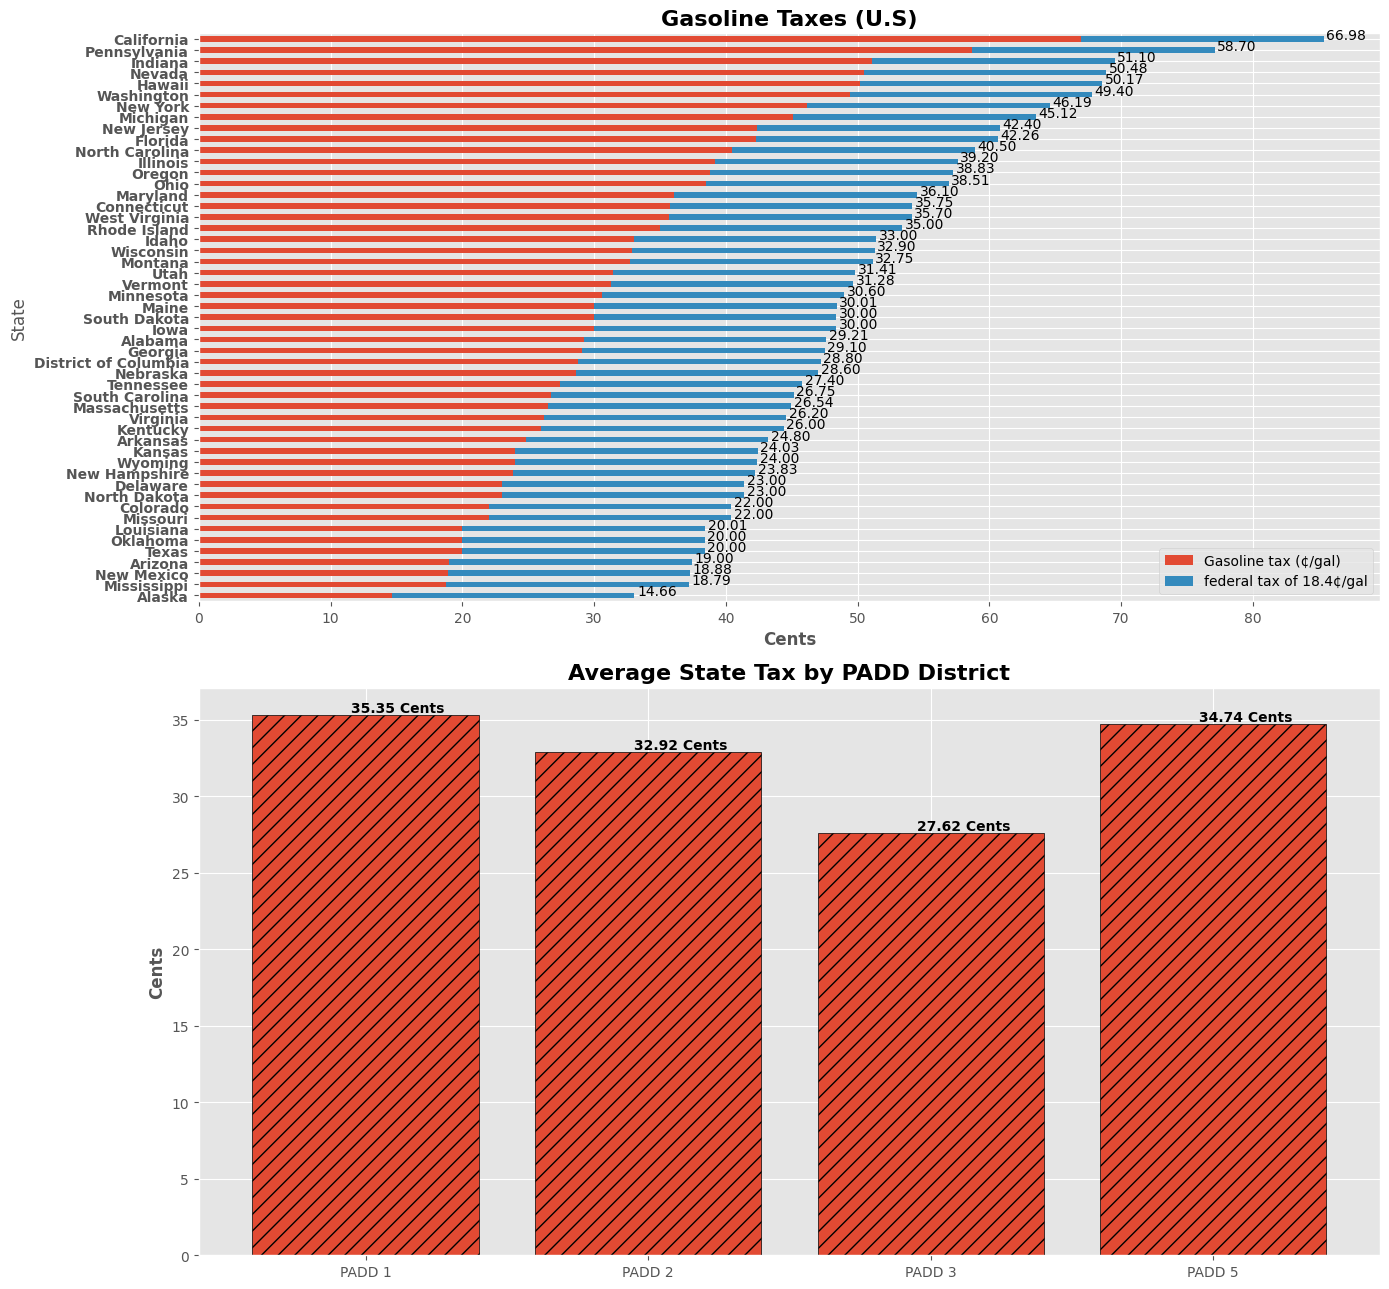

In [79]:
fig = plt.figure(figsize=(14,13))
ax = fig.add_subplot(2,1,1) 
tax_df[tax_df.columns.tolist()[:2] + [ tax_df.columns[-2] ] ].sort_values(by=tax_df.columns.tolist()[1], ascending=True).set_index('State').plot(kind='barh', stacked=True, ax=ax)
ax.set_title("Gasoline Taxes (U.S)", fontweight='bold', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold') 
ax.set_xlabel("Cents", fontweight='bold')

states, taxes = zip(*tax_df[tax_df.columns.tolist()[:2] + [ tax_df.columns[-2] ] ].sort_values(by=tax_df.columns.tolist()[1], ascending=True).set_index('State').apply(lambda row: row[tax_df.columns.tolist()[1]] + row[tax_df.columns.tolist()[-2]] , axis=1).to_dict().items())
for index,tax in enumerate(taxes): 
    ax.annotate(text=f"{tax-18.4:.2f}", xy=(tax + 0.2,index))

ax = fig.add_subplot(2,1,2)
ax.bar(x=list(padd_district), height=list(avg_state_tax), hatch='//', ec='k')
ax.set_title("Average State Tax by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Cents", fontweight='bold')

for index,state_tax in enumerate(avg_state_tax):
    ax.annotate(text=f"{state_tax:.2f} Cents", xy=(index - 0.05, state_tax + 0.184), fontweight='bold')

plt.tight_layout() 

## **ODIN-Legacy Pricing** 

In [3]:
query: str = """
SELECT 
    l.gas_station AS `gas_station_name`, 
    l.price, 
    l.timestamp AS `postedtime`, 
    l.state, 
    l.latitude, 
    l.longitude, 
    CONCAT( l.address, ', ', l.city, ', ',  l.state, ', ', l.zip_code  ) AS `store_address`
FROM legacy_gasoline_pricing l 
"""
legacy_pricing: ODINSpark = ODINSpark(app_name='ODIN Legacy Pricing').exec_odin_mysql_query(query=query)
legacy_pricing.show(5) 


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm

:: loading settings :: url = jar:file:/opt/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7ffb8af9-3f2f-4aa3-9ca4-d022671ca30a;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 474ms :: artifacts dl 15ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evi

+--------------------+-----+----------+-----+---------------+----------------+--------------------+
|    gas_station_name|price|postedtime|state|       latitude|       longitude|       store_address|
+--------------------+-----+----------+-----+---------------+----------------+--------------------+
|               Shell|  0.0|      NULL|   PR|      18.469372|      -67.152922|FR9W+QRV, Ave Dr ...|
|Torrecilla Servic...|  0.0|      NULL|   PR|     18.1892275|     -66.3475681|PR-156, Barranqui...|
|              Texaco|  0.0|      NULL|   PR|      18.384787|      -66.144218|Ave. Aguas Buenas...|
|               Shell|  0.0|      NULL|   FL|28.308393432147| -81.42654620111|2201 W Columbia A...|
|            Marathon|  0.0|      NULL|   FL|26.286835556923|-80.110695362091|4517 N Dixie Hwy,...|
+--------------------+-----+----------+-----+---------------+----------------+--------------------+
only showing top 5 rows



## **Current Gasoline Pricing** 

In [4]:
query: str = """ 
SELECT 
    g.gas_station_name, 
    g.price, 
    g.postedtime, 
    g.state, 
    g.latitude, 
    g.longitude, 
    CONCAT( g.address, ', ', g.city, ', ',  g.state, ', ', g.zip_code  ) AS `store_address`
FROM gasoline_pricing g 
"""
gasoline_pricing: ODINSpark = ODINSpark(app_name="Current Gasoline Pricing").exec_odin_mysql_query(query=query)

# Merged Legacy & Current Pricing Together  
merged_pricing: 'DataFrame' = gasoline_pricing.union(legacy_pricing) 
merged_pricing = merged_pricing.dropna(subset=['gas_station_name', 'latitude', 'longitude' ] )  
merged_pricing = merged_pricing.dropna(subset='postedtime')  
merged_pricing = merged_pricing.withColumn('price', convert_gasoline_price_to_decimal('price').cast('double').alias('price') )
merged_pricing = merged_pricing.withColumn('transc_date', f.date_format('postedtime', 'yyyy-MM-dd').alias('transc_date') )
merged_pricing = merged_pricing.withColumn('padd_district', mapped_padd_district('state').alias('padd_district') )
merged_pricing = merged_pricing.withColumn('state', f.trim( f.when( f.length( f.trim('state').alias('state')) == 2, f.col('state')).otherwise("Invalid").alias('state')).alias('state')  )
merged_pricing = merged_pricing.filter("state != 'Invalid' ").filter("postedtime != 'None' ").orderBy('transc_date')

merged_pricing.show(5)

DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmms   
          `hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdsoo+ososmmmmmmmmmmmmmmmmmmmm

+-------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+-------------+
|   gas_station_name|price|          postedtime|state|       latitude|        longitude|       store_address|transc_date|padd_district|
+-------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+-------------+
|            Chevron| 2.89|2023-05-19T21:28:...|   GA|33.353470102796| -84.120844602584|4860 Bill Gardner...| 2023-05-19|       PADD 3|
|       Bolla Market| 3.23|2023-05-19T19:20:...|   NY|      40.692028|        -73.39747|1201 Sunrise Hwy,...| 2023-05-19|       PADD 1|
|            Safeway| 4.57|2023-05-19T16:45:...|   HI| 21.32794650025|-158.021469712257|91-1119 Keaunui D...| 2023-05-19|       PADD 5|
|        Hanson Mart| 3.19|2023-05-19T16:42:...|   MD|39.424574738401| -76.312236785888|1713 Hanson Rd, E...| 2023-05-19|       PADD 1|
|Jan’s Smoke Shop II|  3.1|2023-05-19T22:20:...|

In [6]:
merged_pricing.printSchema() 

root
 |-- gas_station_name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- postedtime: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- store_address: string (nullable = true)
 |-- transc_date: string (nullable = true)



## **Avg Gasoline Pricing (`EIA`)**

In [7]:
ca_df: 'CaliforniaPricing' = merged_pricing.filter(f.col('state') == 'CA' ).withColumn('before_tax',  f.round( (f.col('price') - (0.6698 + 0.184 )).alias('before_tax'), 2)  )
ca_df = ca_df.withColumn('transc_date', f.date_format('postedtime', 'yyyy-MM-dd' ) ) 
ca_df = ca_df.withColumn('month_name', get_month_name(f.col('transc_date')) )
ca_df = ca_df.dropna(subset='transc_date')

daily_pricing: List[Dict] = [ item.asDict() for item in ca_df.select('postedtime', 'price', 'before_tax' ).collect() ] 
daily_pricing_df: 'DataFrame' = pd.DataFrame( daily_pricing)
daily_pricing_df = daily_pricing_df.astype(str).query(f"postedtime != 'None' ")
daily_pricing_df['postedtime'] = pd.to_datetime(daily_pricing_df['postedtime'] )
daily_pricing_df['price'] = daily_pricing_df['price'].astype(float) 
daily_pricing_df['before_tax'] = daily_pricing_df['before_tax'].astype(float) 

premium_gasoline_ca: 'DataFrame' = odin_eia.get_conventional_premium_gasoline(state_name='california')
premium_gasoline_ca['period'] = pd.to_datetime(premium_gasoline_ca['period'] ) 
premium_gasoline_ca = premium_gasoline_ca.rename({'value': 'avg_price'}, axis=1)

ca_df.show(5) 

+------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+----------+----------+
|  gas_station_name|price|          postedtime|state|       latitude|        longitude|       store_address|transc_date|before_tax|month_name|
+------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+----------+----------+
|Wintun Mini Market| 4.32|2024-05-05T15:25:...|   CA|       39.25746|       -122.03053|3790 State Hwy 45...| 2024-05-05|      3.47|       May|
|          Sinclair| 4.49|2024-05-06T11:55:...|   CA|      33.870384|      -117.943363|1101 W Commonweal...| 2024-05-06|      3.64|       May|
|          Sinclair| 4.59|2024-05-06T13:07:...|   CA|      33.870384|      -117.943363|1101 W Commonweal...| 2024-05-06|      3.74|       May|
|            Costco| 4.39|2024-05-06T14:26:...|   CA|33.802444959425|-116.388974413276|72800 Dinah Shore...| 2024-05-06|      3.54|       May|

## **Distribution of Daily Gasoline Pricing and Average Premium Gasoline Pricing in `California`** 
- Highest State + Federal Tax

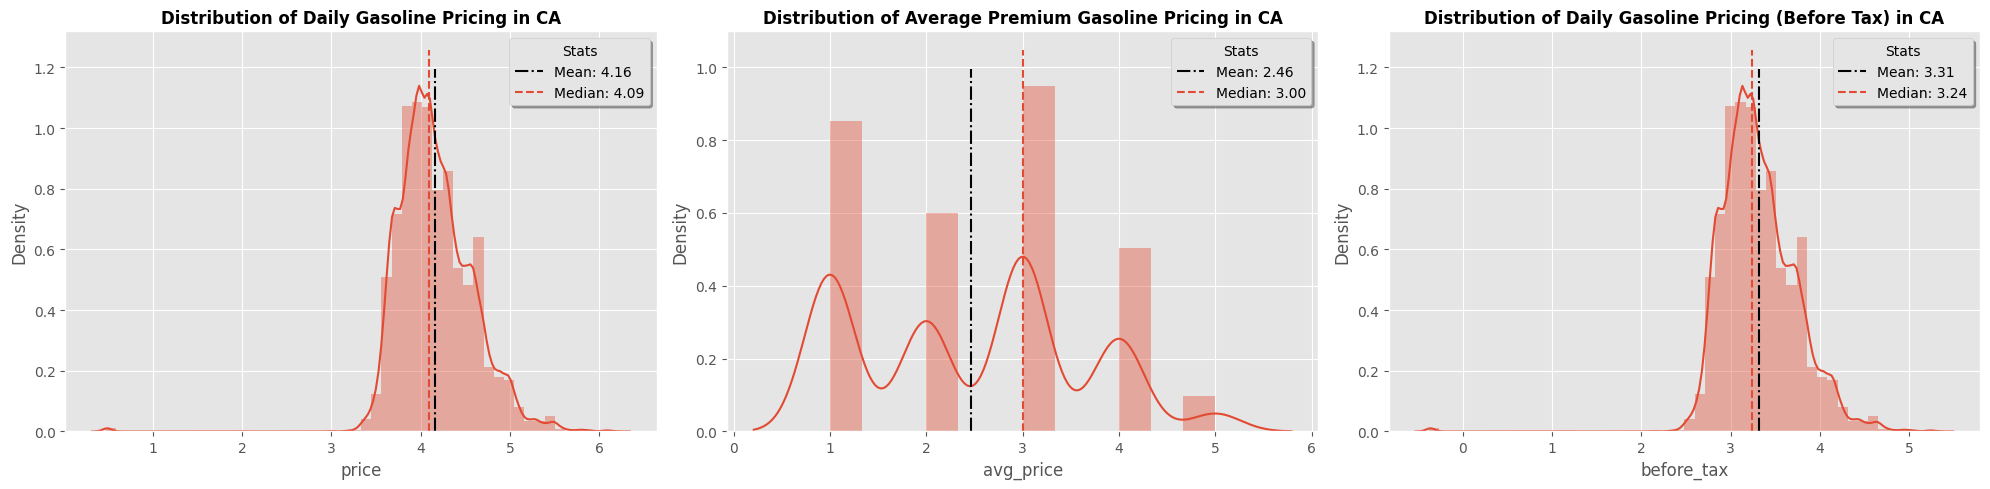

In [16]:
fig = plt.figure(figsize=(20,5))

# Daily Gasoline Pricing 
ax = fig.add_subplot(1,3,1)

mean: float = daily_pricing_df['price'].mean() 
median: float = daily_pricing_df['price'].median() 

sns.distplot( daily_pricing_df['price'],ax=ax )
ax.set_title("Distribution of Daily Gasoline Pricing in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)

# Average Premium Gasoline Pricing 
ax = fig.add_subplot(1,3,2)
mean: float = premium_gasoline_ca['avg_price'].mean() 
median: float = premium_gasoline_ca['avg_price'].median() 

sns.distplot( premium_gasoline_ca['avg_price'],ax=ax )
ax.set_title("Distribution of Average Premium Gasoline Pricing in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)

# Before Tax Pricing (Daily) 
ax = fig.add_subplot(1,3,3)
mean: float = daily_pricing_df['before_tax'].mean() 
median: float = daily_pricing_df['before_tax'].median() 

sns.distplot( daily_pricing_df['before_tax'],ax=ax )
ax.set_title("Distribution of Daily Gasoline Pricing (Before Tax) in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)


plt.tight_layout() 

## **Avg Daily/Weekly Regular & Premium Gasoline Price Trends (Duration: May - June 2024)** 

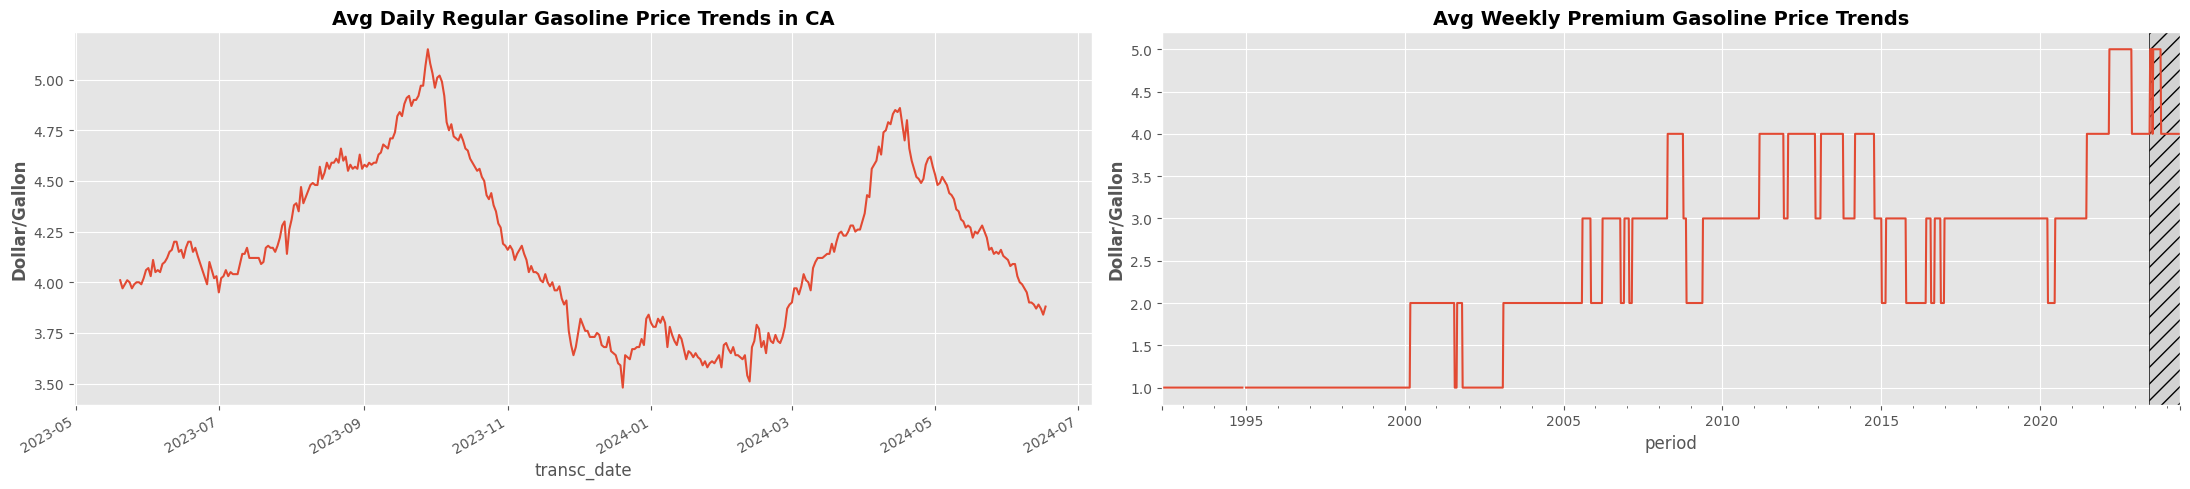

In [18]:
avg_gasoline_price: 'DataFrame' = pd.DataFrame([ item.asDict() for item in ca_df.groupBy('transc_date').agg(f.round(f.avg('price'), 2).alias('avg_price') ).collect() ]) 
avg_gasoline_price['transc_date'] = pd.to_datetime(avg_gasoline_price['transc_date'] )

fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(1,2,1)
avg_gasoline_price.set_index('transc_date')['avg_price'].plot(ax=ax)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_title("Avg Daily Regular Gasoline Price Trends in CA", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
premium_gasoline_ca.set_index('period')['avg_price'].sort_index().plot(ax=ax) 
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_title("Avg Weekly Premium Gasoline Price Trends", fontweight='bold', fontsize=14)
ax.axvspan(xmin=2789 , xmax=2840, ec='k', fc='lightgray', hatch='//')

plt.tight_layout() 

## **Average Gasoline Price by State**

In [97]:
avg_gasoline_prices_by_state: 'DataFrame' = pd.DataFrame( [ item.asDict() for item in  merged_pricing.filter("state != 'Invalid' ").groupBy('state').agg(f.round( f.avg('price'),2 ).alias('avg_price') ).orderBy('avg_price').collect() ] )
states,avg_prices = zip(*avg_gasoline_prices_by_state.set_index('state').to_dict().get('avg_price').items()  )

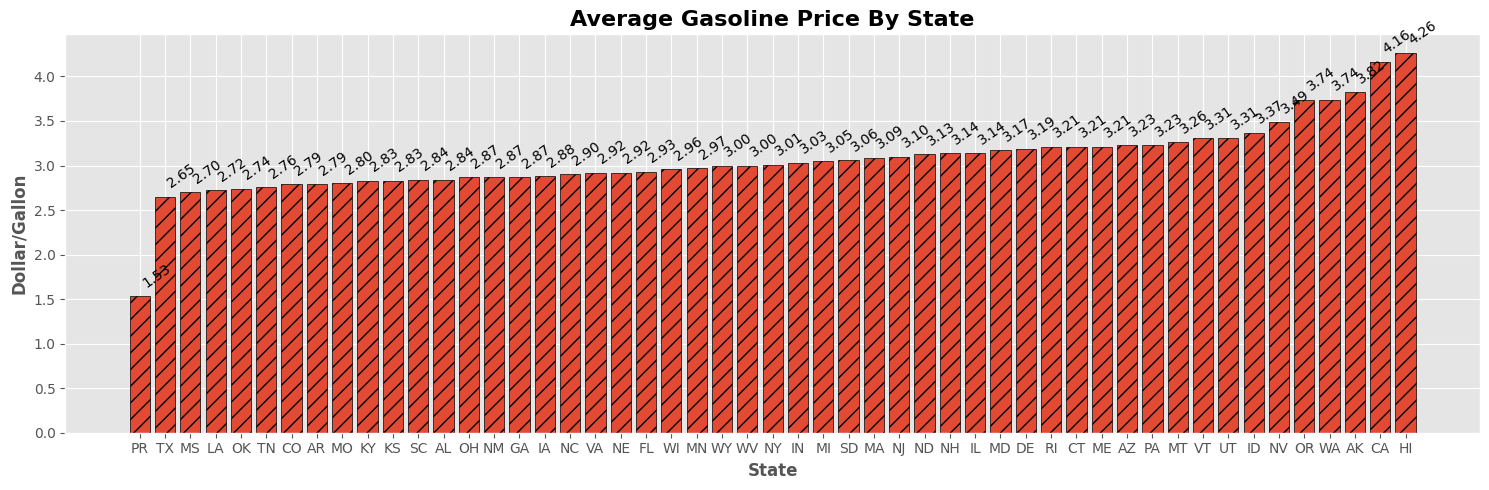

In [110]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot() 

ax.bar(x=list(states), height=list(avg_prices), ec='k', hatch='//')
ax.set_title("Average Gasoline Price By State", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_xlabel("State", fontweight='bold')

for index,price in enumerate(avg_prices):
    ax.annotate(text=f"{price:.2f}", xy=(index,price + 0.1), rotation=35)
plt.tight_layout() 

## **Average Gasoline Price by PADD District** 

In [69]:
merged_pricing.filter( "padd_district != 'N/A' ").filter("padd_district != 'Not Applicable' " ).groupBy('padd_district').agg(f.round( f.avg('price'),2).alias('avg_price') ).orderBy('avg_price').show() 

+-------------+---------+
|padd_district|avg_price|
+-------------+---------+
|       PADD 3|     2.82|
|       PADD 2|     2.97|
|       PADD 1|     3.17|
|       PADD 5|     3.42|
+-------------+---------+



## **Gasoline Prices by Formulation, Grade, Sales Type (`EIA`)** 

In [16]:
odin_secrets.get_secrets(secret_name='afghan_project').get('eia_url')

'https://api.eia.gov/v2/petroleum/pri/allmg/data/?api_key=3zjKYxV86AqtJWSRoAECir1wQFscVu6lxXnRVKG8&frequency=monthly&data[0]=value&facets[series][]=EMA_EPMR_PTA_NUS_DPG&start=1983-01&end=2022-03&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'

In [17]:
gasoline_price_by_prodcuts: 'DataFrame' = get_gasoline_prices_by_products(url=odin_secrets.get_secrets(secret_name='afghan_project').get('eia_url'))
gasoline_price_by_prodcuts['period'] = gasoline_price_by_prodcuts['period'].apply(lambda row: pd.to_datetime( "%s-01" % (row) ) )
gasoline_price_by_prodcuts['value'] = gasoline_price_by_prodcuts['value'].astype(float) 
gasoline_price_by_prodcuts.head(10)

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2022-02-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
1,2022-01-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
2,2021-12-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
3,2021-11-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
4,2021-10-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
5,2021-09-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
6,2021-08-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
7,2021-07-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
8,2021-06-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
9,2021-05-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL


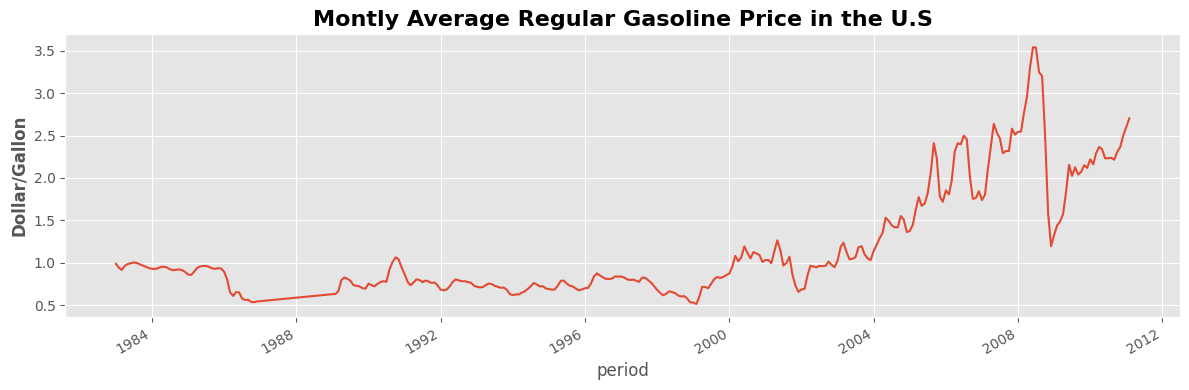

In [23]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot() 

gasoline_price_by_prodcuts[~gasoline_price_by_prodcuts['value'].isna()].set_index('period')['value'].replace({np.nan:0.0}).sort_index().plot(ax=ax)
ax.set_title("Montly Average Regular Gasoline Price in the U.S", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
plt.tight_layout() 

## **Gasoline Prices Comparison (`CA, PA, HI, WA, TX`)** 
- `Figure 1.2` shows that PADD 5 has the highest gasoline avg_price due to higher tax (both state & federal) 

In [11]:
comp_prices: 'DataFrame' = merged_pricing.filter("state == 'WA' ").dropna(subset='postedtime').union(merged_pricing.filter("state == 'HI' ").dropna(subset='postedtime')).union(merged_pricing.filter("state == 'CA' ").dropna(subset='postedtime')).union(merged_pricing.filter("state == 'PA' ").dropna(subset='postedtime')) 
pricing_comp_df: 'DataFrame' = pd.DataFrame([ item.asDict() for item in comp_prices.select('postedtime', 'padd_district', 'state', 'price' ).collect() ] )
pricing_comp_df['state_name'] = pricing_comp_df['state'].apply(lambda row: INVERSE_STATES.get(row))

# Prices by PADD Districts
padd_prices: 'DataFrame' = pd.DataFrame( [ item.asDict() for item in merged_pricing.filter("padd_district != 'N/A' ").filter("padd_district != 'Not Applicable' ").select('postedtime', 'padd_district', 'state', 'price' ).collect() ] )
padd_prices = padd_prices.astype(str).query("postedtime != 'None' ")
padd_prices['postedtime'] = pd.to_datetime( padd_prices['postedtime'] )
padd_prices['transc_date'] = pd.to_datetime(  padd_prices['postedtime'].apply(lambda row: row.strftime('%Y-%m-%d')  ) )
padd_prices['price'] = padd_prices['price'].astype(float)

comp_prices.show()

+--------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+-------------+
|    gas_station_name|price|          postedtime|state|       latitude|        longitude|       store_address|transc_date|padd_district|
+--------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+-------------+
|Swinomish Markets...| 3.99|2024-05-05T15:26:...|   WA|       48.45662|       -122.51837|12939 Casino Dr, ...| 2024-05-05|       PADD 5|
|              Sunval| 3.98|2024-05-05T19:56:...|   WA|      47.104443|      -119.310603|2777 W Broadway A...| 2024-05-05|       PADD 5|
|    US Big Mini Mart| 4.03|2024-05-05T17:42:...|   WA|       48.47508|       -122.33588|157 S Burlington ...| 2024-05-05|       PADD 5|
|Half-Sun Travel P...| 3.89|2024-05-05T22:40:...|   WA|47.099153135983|-119.318540096283|420 S Wanapum Dr,...| 2024-05-05|       PADD 5|
|           Topp Stop| 3.91|2024-05-05T21

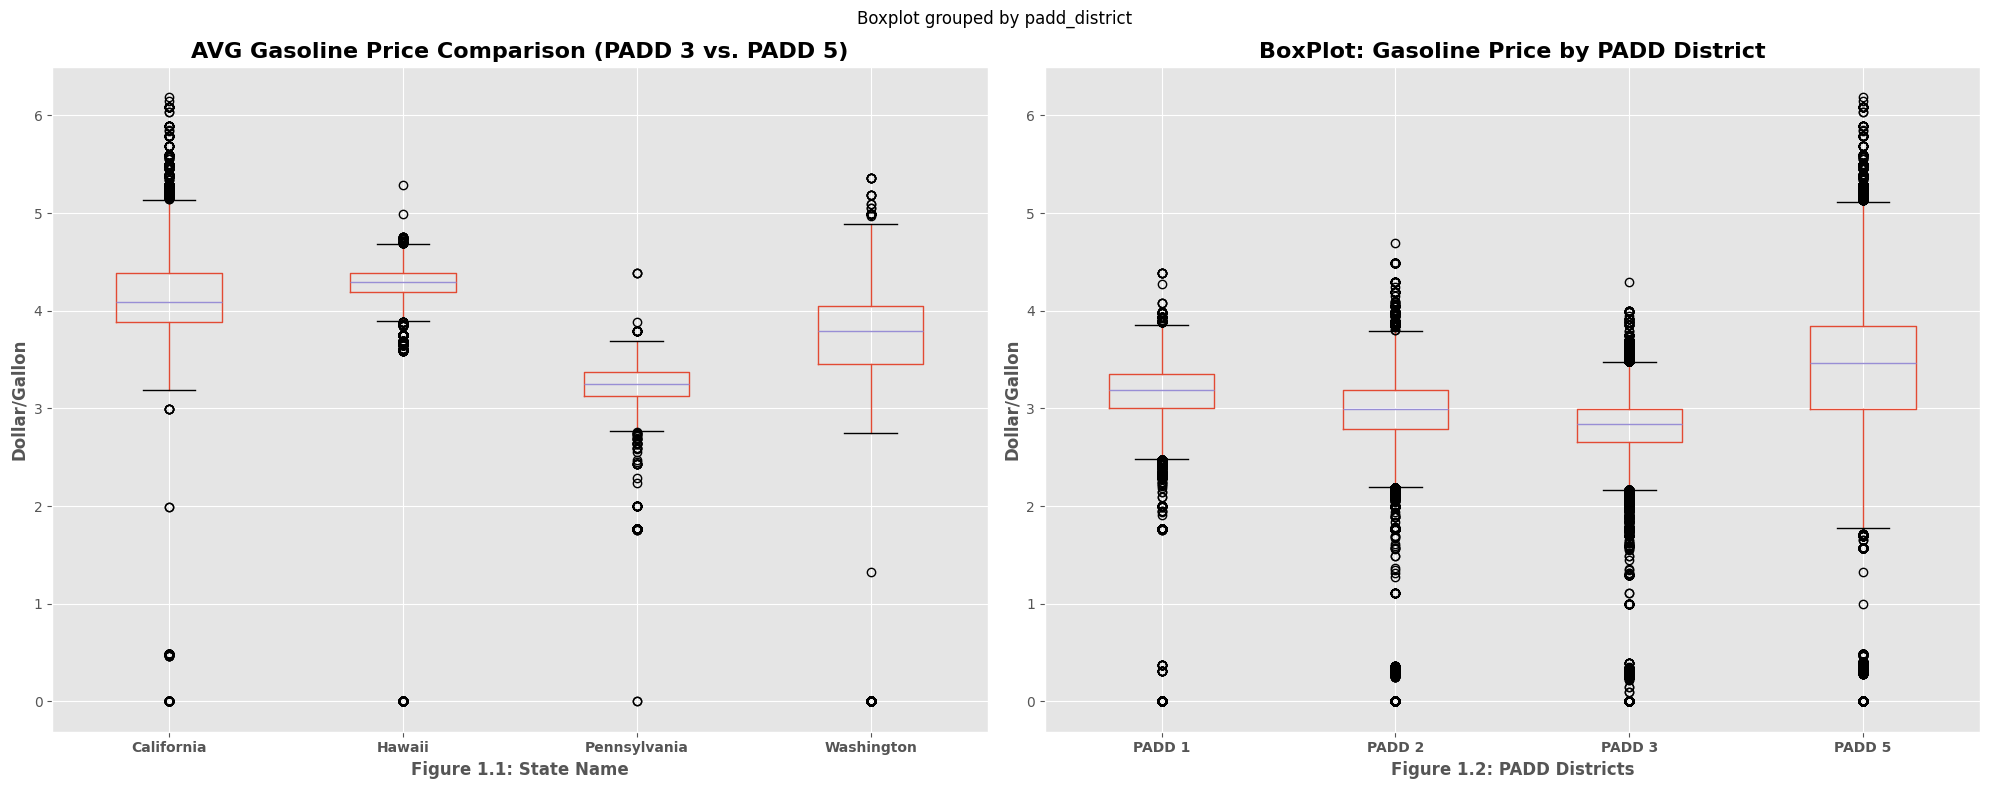

In [80]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1) 
pricing_comp_df.query("padd_district != 'N/A' ").sort_values(by='state_name').boxplot(column='price', by='state_name' ,  ax=ax)
ax.set_title("AVG Gasoline Price Comparison (PADD 3 vs. PADD 5)", fontweight='bold', fontsize=16) # TX having the lowest tax_rate
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels() , fontweight='bold' )
ax.set_xlabel("Figure 1.1: State Name", fontweight='bold')

ax = fig.add_subplot(1,2,2) 
padd_prices.boxplot(by='padd_district', column='price', ax=ax) # PADD 5 has the highest tax_rate (both state & federal) 
ax.set_title("BoxPlot: Gasoline Price by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels() , fontweight='bold' )
ax.set_xlabel("Figure 1.2: PADD Districts", fontweight='bold')

plt.tight_layout() 

## **Daily, Weekly, and Monthly Average Gasoline Price Trends by PADD District** 

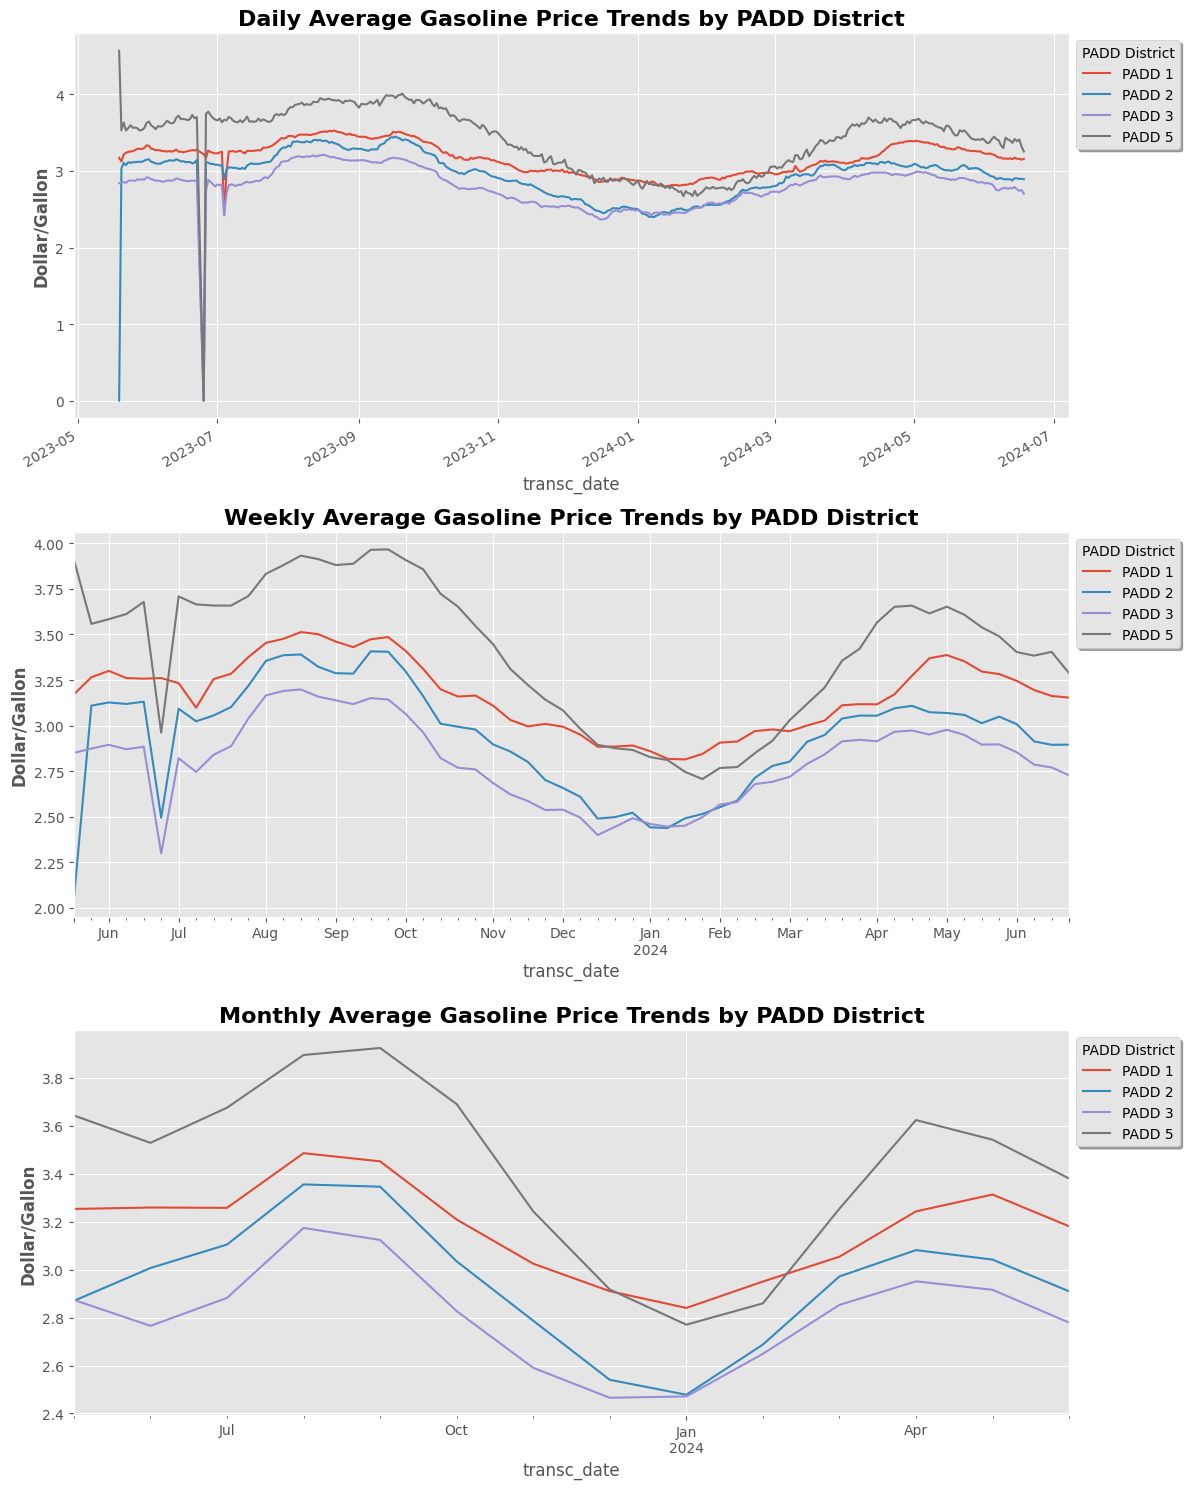

In [147]:
fig = plt.figure(figsize=(12,15))
ax = fig.add_subplot(3,1,1) 
padd_prices.groupby(['padd_district' , 'transc_date'])['price'].mean().unstack('padd_district').replace({np.nan:0.0}).plot(ax=ax) 
ax.set_title("Daily Average Gasoline Price Trends by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.legend(title='PADD District', fancybox=True, shadow=True, bbox_to_anchor=(1,1))

ax = fig.add_subplot(3,1,2) 
padd_prices.groupby(['transc_date', 'padd_district'])['price'].mean().unstack('padd_district').replace({np.nan:0.0}).resample('W').mean().plot(ax=ax) 
ax.set_title("Weekly Average Gasoline Price Trends by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.legend(title='PADD District', fancybox=True, shadow=True, bbox_to_anchor=(1,1))

ax = fig.add_subplot(3,1,3) 
padd_prices.groupby(['transc_date', 'padd_district'])['price'].mean().unstack('padd_district').replace({np.nan:0.0}).resample('M').mean().plot(ax=ax) 
ax.set_title("Monthly Average Gasoline Price Trends by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.legend(title='PADD District', fancybox=True, shadow=True, bbox_to_anchor=(1,1))

plt.tight_layout() 

## **Forecast Gasoline Pricing in `PADD 5` District**
1. Model One: Endog: (price)
2. Model Two: Endog: (price) Exog: (`State`, `State tax`, `Other taxes & Fees[2]`,	`Total State[3]`, `State & Federal`, `Month`, `Year`)
3. Model Three: Endog: (price) Exog: (`Taxes` (both State & Fed) + `Import/Export` based on PADD District )

In [7]:
gasoline_prices_df: 'DataFrame' = pd.DataFrame([  item.asDict() for item in merged_pricing.filter("padd_district == 'PADD 5' ").groupBy('transc_date').agg(f.round( f.avg('price'),2).alias('avg_price') ).orderBy('transc_date').collect() ]) # mem_alloc: 5.78G 
gasoline_prices_df['transc_date'] = pd.to_datetime(gasoline_prices_df['transc_date'] ) 
gasoline_prices_df['year'] = gasoline_prices_df['transc_date'].apply(lambda row: row.year) 
gasoline_prices_df['month'] = gasoline_prices_df['transc_date'].apply(lambda row: row.month) 

# Average Tax for PADD 5 (both State/Fed)
avg_tax_padd5: 'DataFrame' = tax_df[ tax_df.query("PADD_DISTRICT == 'PADD 5' ").iloc[:,1:5].columns.tolist() + ['tax_month'] ].groupby('tax_month')[tax_df.columns.tolist()[2:5] ].mean() 

## **Applying Federal & State Taxes on PADD-5 Daily Gasoline Pricing**

In [8]:
results: List = [] # exog_variables 
for r in gasoline_prices_df.iterrows():

    current_tax_bracket: 'DataFrame' = avg_tax_padd5.iloc[pd.DataFrame( avg_tax_padd5.index ).apply(lambda row: r[1]['transc_date'] > pd.to_datetime( row) ).replace({False:np.nan}).dropna().index.tolist() ].sort_index().tail(1) 
    
    current_row: Dict = current_tax_bracket.to_dict(orient='records')[0] if current_tax_bracket.to_dict(orient='records') else {'Other taxes & Fees[2]': 0.0, 'Total State[3]': 0.0, 'State & Federal': 0  } 
    results.append({**{'transc_date': r[1]['transc_date'], 
                    'avg_price':r[1]['avg_price']}, **current_row} )

padd5_pricing_df: 'DataFrame' = pd.DataFrame( results) 

## **PADD 5 Gasoline Pricing Seasonal Trend-Decomposition** 
- The seasonal graph shows that there is a weekly cyclical pattern (i.e., 2023-07 2023-09), indicating there is a seaonal pattern. 

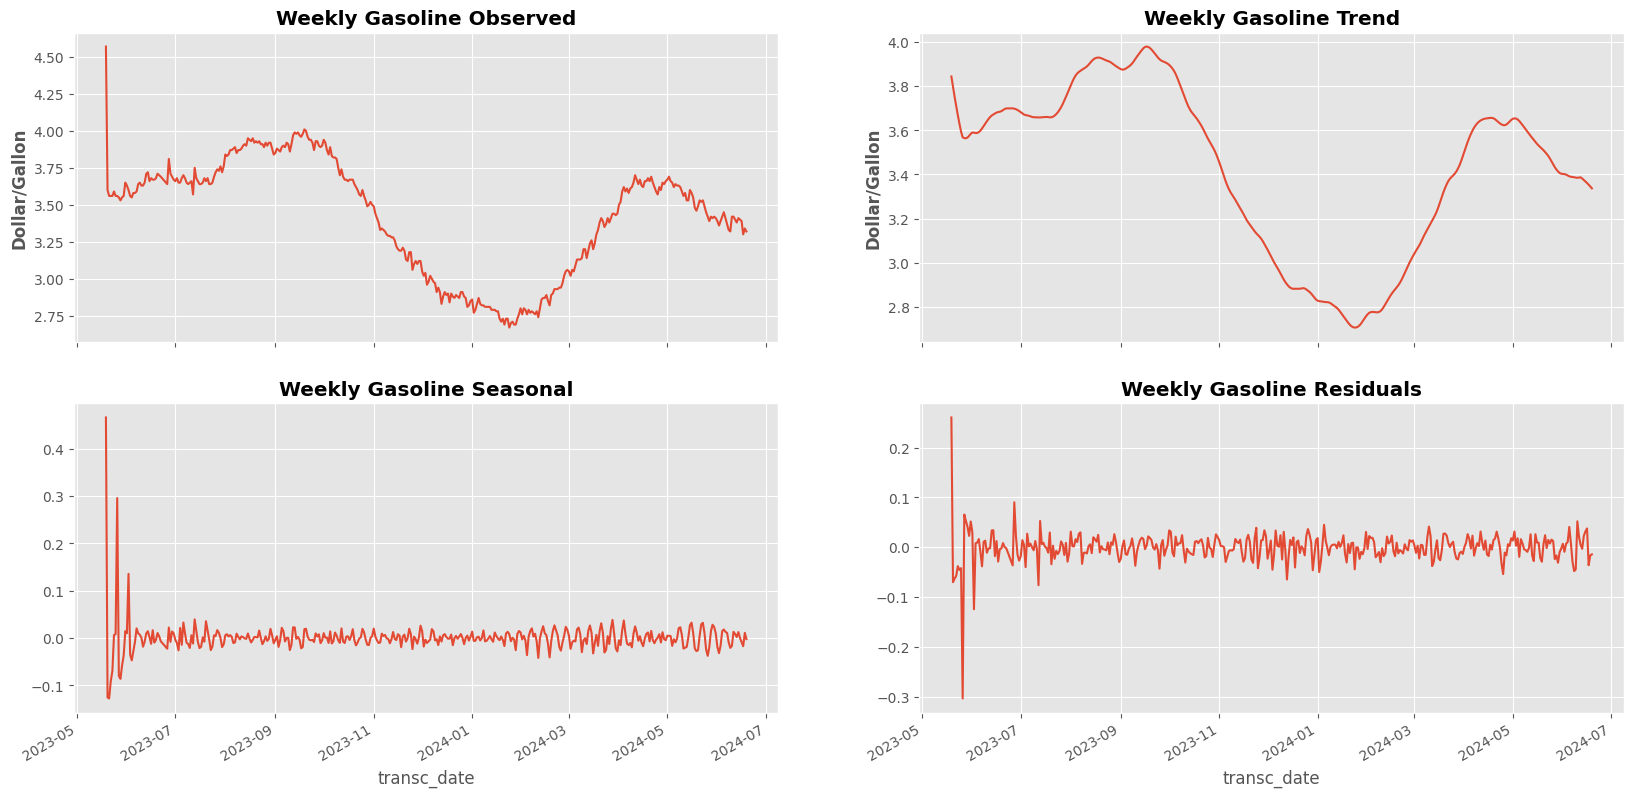

In [158]:
padd_decomp: STL = STL(padd5_pricing_df.set_index('transc_date')['avg_price'], period=7 ).fit() 
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2,2,1)
padd_decomp.observed.plot(ax=ax) 
ax.set_title("Weekly Gasoline Observed", fontweight='bold')
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax = fig.add_subplot(2,2,2)
padd_decomp.trend.plot(ax=ax) 
ax.set_title("Weekly Gasoline Trend", fontweight='bold')
ax.set_ylabel("Dollar/Gallon", fontweight='bold')

ax = fig.add_subplot(2,2,3)
padd_decomp.seasonal.plot(ax=ax) 
ax.set_title("Weekly Gasoline Seasonal", fontweight='bold') # There is a weekly cyclical pattern (i.e., 2023-07 2023-09), indicating there is a seaonal pattern 

ax = fig.add_subplot(2,2,4)
padd_decomp.resid.plot(ax=ax) 
ax.set_title("Weekly Gasoline Residuals", fontweight='bold')

fig.autofmt_xdate() 

## **Plotting Autocorrelation and Partial-Autocorrelation for Gasoline Pricing PADD5** 
- Looking at the 100 lags, the sinusoidal/decaying pattern for the acf plots indicates that there is a presence of autoregressive process.
- Looking at the 100 steps, the sinusoidal/decaying pattern for the partial-autocorrelation plot indicates that there is a mix between `AR`&`MA` processes.
- Also, the seasonal graph above shows that there is a seasonal/cyclical pattern.

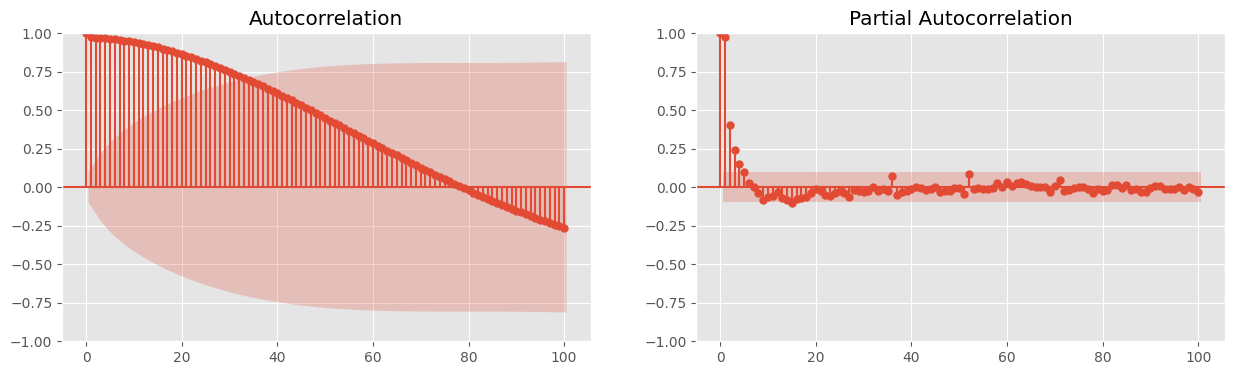

In [203]:
fig = plt.figure(figsize=(15,4)) 
ax = fig.add_subplot(1,2,1)

acf_ax = plot_acf(padd5_pricing_df.set_index('transc_date')['avg_price'], lags=100, ax=ax)

ax = fig.add_subplot(1,2,2)

pacf_ax = plot_pacf(padd5_pricing_df.set_index('transc_date')['avg_price'], lags=100, ax=ax)

## **Applying Adfuller Test on PADD-5 Weekly Gasoline Pricing** 

In [176]:
results: adfuller= list(adfuller( padd5_pricing_df.set_index('transc_date')['avg_price'] ))[:2]
pd.DataFrame(results).transpose().rename({0:'Adfuller', 1: 'P-Value'},axis=1)

,Adfuller,P-Value
0,-1.742881,0.409165


### **Applying First Order Differencing** 
- NOTE: Because p-value still > 0.05 

In [178]:
integration_diff: int = np.diff(padd5_pricing_df.set_index('transc_date')['avg_price'])
results: adfuller= list(adfuller( integration_diff))[:2]
pd.DataFrame(results).transpose().rename({0:'Adfuller', 1: 'P-Value'},axis=1)

,Adfuller,P-Value
0,-2.562733,0.100947


### **Applying Seasonal Differencing** 
- NOTE: Now p-value is < 0.05 and Adfuller is big negative number

In [179]:
seasonal_diff: int = np.diff(integration_diff)
results: adfuller= list(adfuller( seasonal_diff))[:2]
pd.DataFrame(results).transpose().rename({0:'Adfuller', 1: 'P-Value'},axis=1)

,Adfuller,P-Value
0,-8.939305,9.347057e-15


## **Find The lowest AIC**
- **NOTE**: find the model which has the lowest AIC score and capture the weekly seasonal trends

In [13]:
df: 'Series' = padd5_pricing_df.set_index('transc_date')['avg_price'] 
pkl_path: str = os.path.join(DST_PATH, 'model_one_padd5_comp_jobs.pkl' )
p,q,P,Q = 7,7,7,7
d,D = 1,1 # apply both first-order & seasonal differencing 
s: int = 7 # weekly gasoline pricing trends
optimize_sarimax(p_size=p, d=d, q_size=q, P_size=P, D=D, Q_size=Q, s=s, pkl_path=pkl_path, df=df)

DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Starting at index 1700
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Job Started at 2024-06-19T21:28:26.247482
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(4,1,6,7) @21:28:26
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(5,1,0,7) @21:28:26
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(5,1,1,7) @21:28:26
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(5,1,2,7) @21:28:26
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(5,1,3,7) @21:28:26
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(5,1,4,7) @21:28:27
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(5,1,5,7) @21:28:27
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(4,1,6)(5,1,6,7) @21:28:27
DEBUG:odin_eia_db.sta

In [19]:
pd.read_pickle(pkl_path).sort_values(by='AIC').head(10) 

,p,q,P,Q,AIC
1129,3,2,0,1,-1154.879316
1031,3,0,0,1,-1152.429246
1374,4,0,0,1,-1152.309509
1423,4,1,0,1,-1146.497878
1080,3,1,0,1,-1146.445939
1136,3,2,1,1,-1145.860237
688,2,0,0,1,-1145.783975
51,0,1,0,1,-1145.411322
695,2,0,1,1,-1145.317970
737,2,1,0,1,-1144.685063


## **Model One: SARIMAX(3,1,2)(1,1,1,7)**

In [23]:
train: 'Series' = df[:int(df.shape[0] * 0.8)] 
test: 'Series' = df[ int(df.shape[0] * 0.8):]

In [38]:
model_one: 'SARIMAX' = SARIMAX(endog=train, 
                              order=(3,1,2),
                              seasonal_order=(1,1,1,7),
                              simple_differencing=True,
                              enforce_stationarity=True).fit(disp=False) 

In [39]:
model_one.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     D.DS7.avg_price   No. Observations:                  308
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 7)   Log Likelihood                 400.008
Date:                             Wed, 19 Jun 2024   AIC                           -784.017
Time:                                     21:44:05   BIC                           -754.176
Sample:                                          0   HQIC                          -772.085
                                             - 308                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0987      6.181     -0.016      0.987     -12.212      12.015
ar.L2         -0.2667      0.946     -0.282      0.778      -2.122       1.588
ar.L3         -0.0042      1.164     -0.004      0.997      -2.285       2.277
ma.L1         -0.0949      6.183     -0.015      0.988     -12.214      12.024
ma.L2          0.0927      0.597      0.155      0.877      -1.077       1.263
ar.S.L7       -0.2361      0.033     -7.261      0.000      -0.300      -0.172
ma.S.L7       -0.4474      0.043    -10.504      0.000      -0.531      -0.364
sigma2         0.0043      0.000     33.393      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):             52427.55
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             6.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Model One Diagnostic Plot**

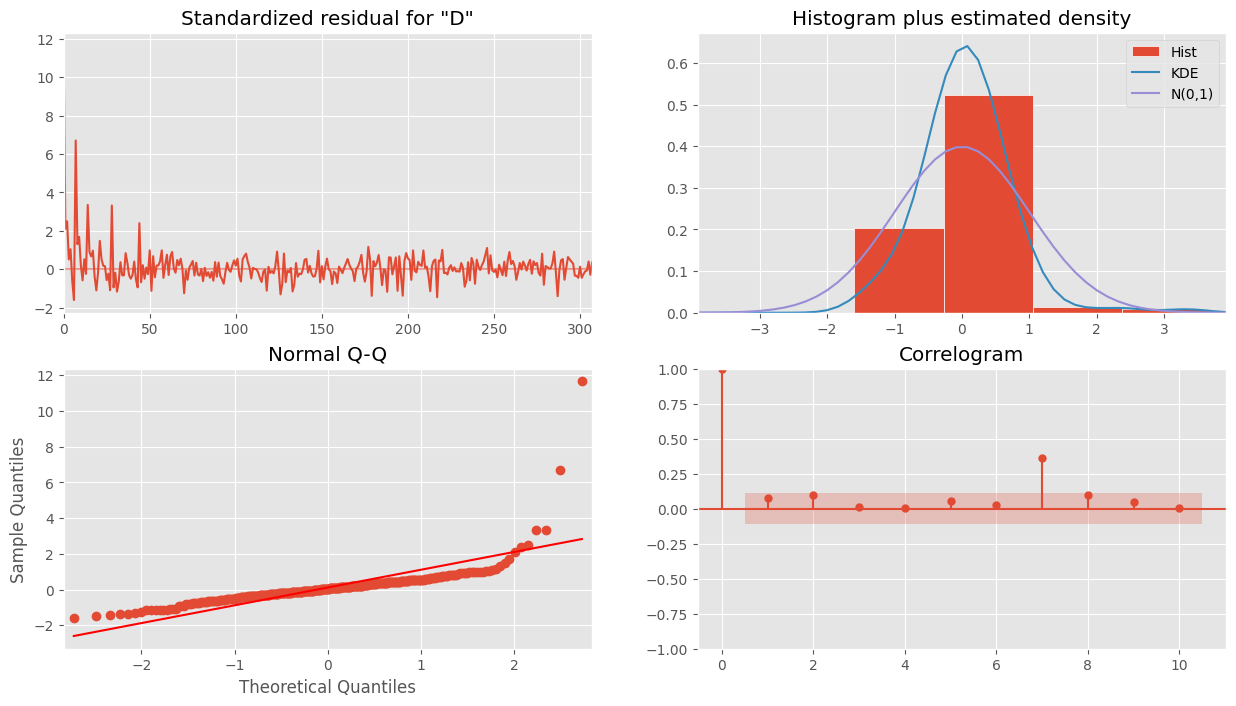

In [40]:
model_one_diag = model_one.plot_diagnostics(figsize=(15,8)) # errors not random 

## **Model One LJungbox Test**
- Model one cannot correctly capture the weekly seasonal price, since p-values after lag 6 < 0.05 (the errors are not random).

In [43]:
pd.DataFrame( acorr_ljungbox(model_one.resid, period=10)['lb_pvalue'] ) # residuals are correlated after lag > 6 

,lb_pvalue
1,8.787588e-02
2,3.145085e-02
3,6.984943e-02
4,1.279307e-01
5,1.714816e-01
6,2.570624e-01
7,7.362991e-08
8,7.128217e-08
9,1.289696e-07
10,3.174681e-07


## **Model One Revision** 
- Aggregate gasoline pricing weekly for PADD 5 District

In [5]:
padd5_district: List[str] = [  STATES_LOOKUP.get(state) for state, region in INVERSE_US_REGIONS.items() if PADD_AREAS.get(region) == 'PADD 5'  ]
args: str = ', '.join(map(lambda item: "'%s'" % (item), padd5_district))

In [6]:
query: str = f"""
(SELECT 
    DATE_FORMAT(g.postedtime, '%Y-%m-%d' ) AS `transc_date`, 
    CAST(g.price AS DECIMAL ) AS `price`
    
FROM gasoline_pricing g 
WHERE g.state IN ({args}) AND g.price != 0)

UNION ALL 

(SELECT 
    DATE_FORMAT(l.timestamp, '%Y-%m-%d' ) AS `transc_date`, 
    CAST(l.price AS DECIMAL ) AS `price`
    
FROM legacy_gasoline_pricing l
WHERE l.state IN ({args}) AND l.price != 0 )

"""

historical_pricing: 'DataFrame' = ODINSpark(app_name='Forecast Gasoline Pricing in PADD 5 District').exec_odin_mysql_query(query=query)  


DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmms   
          `hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdsoo+ososmmmmmmmmmmmmmmmmmmmm

:: loading settings :: url = jar:file:/opt/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9dd904ca-b6d6-4ed2-8711-64f948d6e0f8;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 305ms :: artifacts dl 11ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evi

In [8]:
gasoline_weekly_pricing: 'DataFrame' = pd.DataFrame( [ item.asDict() for item in historical_pricing.groupBy(f.window('transc_date', '1 Week')).agg(f.round( f.avg('price'),2).alias('avg_price')).fillna(0.0).collect() ] ) 
gasoline_weekly_pricing['transc_date'] = gasoline_weekly_pricing['window'].apply(lambda row: row[1].strftime('%Y-%m-%d')) 
gasoline_weekly_pricing['transc_date'] = pd.to_datetime( gasoline_weekly_pricing['transc_date'])
gasoline_weekly_pricing['avg_price'] = gasoline_weekly_pricing['avg_price'].astype(float)

# Premium Gasoling (Source: EIA.gov) 
premium_gasoline_pricing: 'PADD5-District' = odin_eia.get_conventional_premium_gasoline(state_name='washington')[['period','value']].to_dict(orient='records') + \
                                             odin_eia.get_conventional_premium_gasoline(state_name='colorado')[['period','value']].to_dict(orient='records')  + \
                                             odin_eia.get_conventional_premium_gasoline(state_name='california')[['period','value']].to_dict(orient='records') 

bench_mark_df: 'DataFrame' = pd.DataFrame( premium_gasoline_pricing) 
bench_mark_df['value'] = bench_mark_df['value'].astype(float) 
bench_mark_df['period'] = pd.to_datetime(bench_mark_df['period'])

weekly_pricing_padd5: 'Series' = gasoline_weekly_pricing.set_index('transc_date')['avg_price']

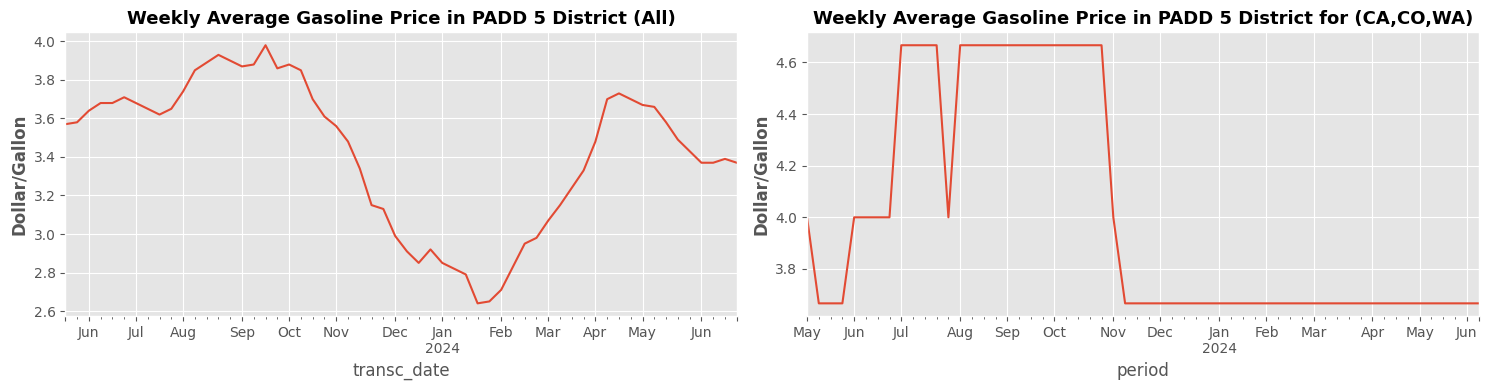

In [89]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
gasoline_weekly_pricing.set_index('transc_date')['avg_price'].sort_index().plot(ax=ax)
ax.set_title("Weekly Average Gasoline Price in PADD 5 District (All)", fontweight='bold', fontsize=13)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')

ax = fig.add_subplot(1,2,2)
bench_mark_df.set_index('period').resample('W')['value'].mean().loc['2023-05':].plot(ax=ax)
ax.set_title("Weekly Average Gasoline Price in PADD 5 District for (CA,CO,WA)", fontweight='bold', fontsize=13)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')

plt.tight_layout() 

## **Weekly Gasoline Price Mean and Variance Overtime in PADD 5 District** 

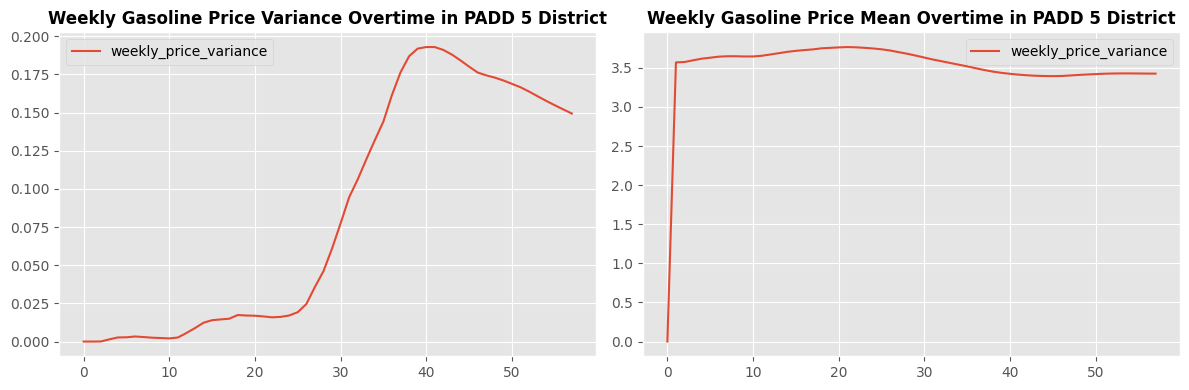

In [40]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
pd.DataFrame( [ weekly_pricing_padd5.sort_index().iloc[:index].var() for index in range(weekly_pricing_padd5.shape[0]) ] ).replace({np.nan:0.0}).rename({0:'weekly_price_variance'},axis=1).plot(ax=ax) 
ax.set_title("Weekly Gasoline Price Variance Overtime in PADD 5 District", fontweight='bold', fontsize=12)

ax = fig.add_subplot(1,2,2)
pd.DataFrame( [ weekly_pricing_padd5.sort_index().iloc[:index].mean() for index in range(weekly_pricing_padd5.shape[0]) ] ).replace({np.nan:0.0}).rename({0:'weekly_price_variance'},axis=1).plot(ax=ax) 
ax.set_title("Weekly Gasoline Price Mean Overtime in PADD 5 District", fontweight='bold', fontsize=12)

plt.tight_layout() 

## **Decompose Seasonal Trend Weekly Gasoline Pricing**

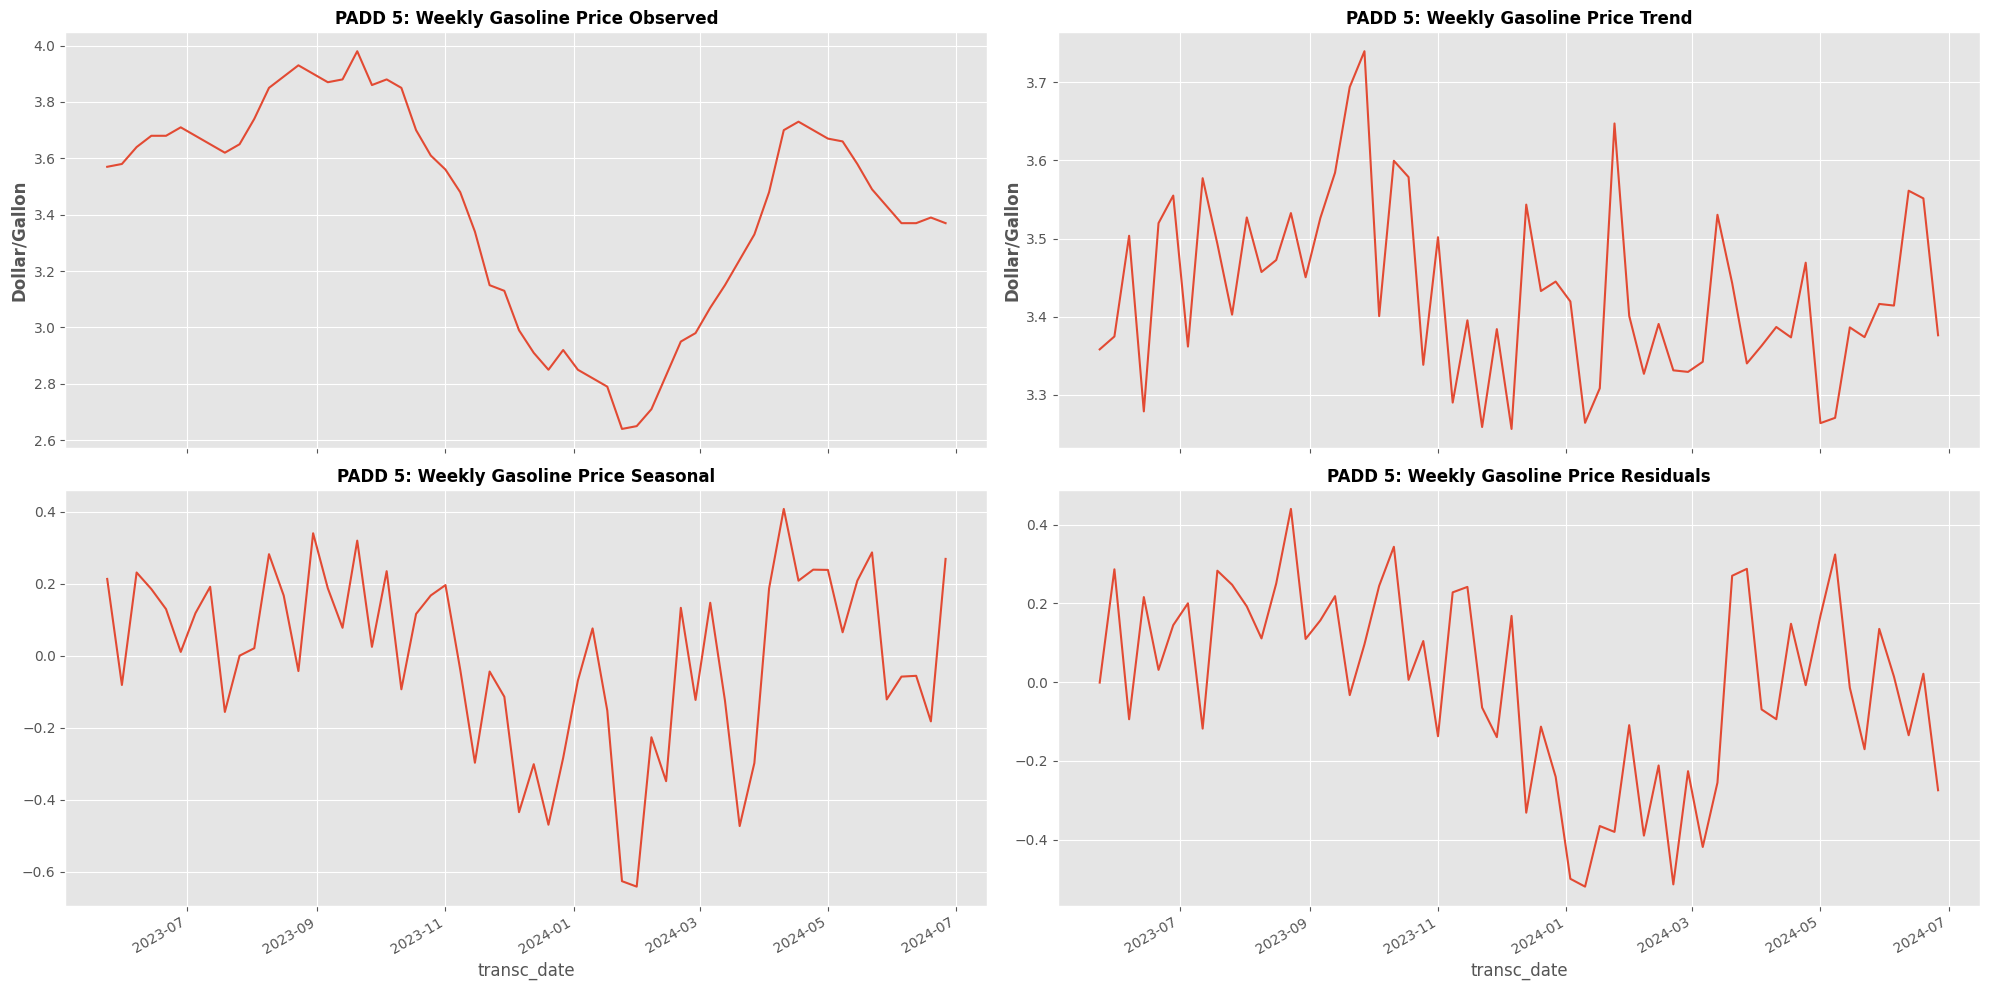

In [17]:
padd5_stl: STL = STL( weekly_pricing_padd5, period=7).fit() 

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,2,1) 
padd5_stl.observed.plot(ax=ax) 
ax.set_title("PADD 5: Weekly Gasoline Price Observed", fontweight='bold', fontsize=12)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')

ax = fig.add_subplot(2,2,2) 
padd5_stl.trend.plot(ax=ax) 
ax.set_title("PADD 5: Weekly Gasoline Price Trend", fontweight='bold', fontsize=12)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')

ax = fig.add_subplot(2,2,3) 
padd5_stl.seasonal.plot(ax=ax) 
ax.set_title("PADD 5: Weekly Gasoline Price Seasonal", fontweight='bold', fontsize=12)

ax = fig.add_subplot(2,2,4) 
padd5_stl.resid.plot(ax=ax) 
ax.set_title("PADD 5: Weekly Gasoline Price Residuals", fontweight='bold', fontsize=12)

fig.autofmt_xdate()
plt.tight_layout() 

## **Plot Autocorrelation and Partial Autocorrelation** 
- The autocorrelation plot shows that there is no correlation after lag zero, which indicates that we are dealing with a random walk (There is no relations between them/lags). 

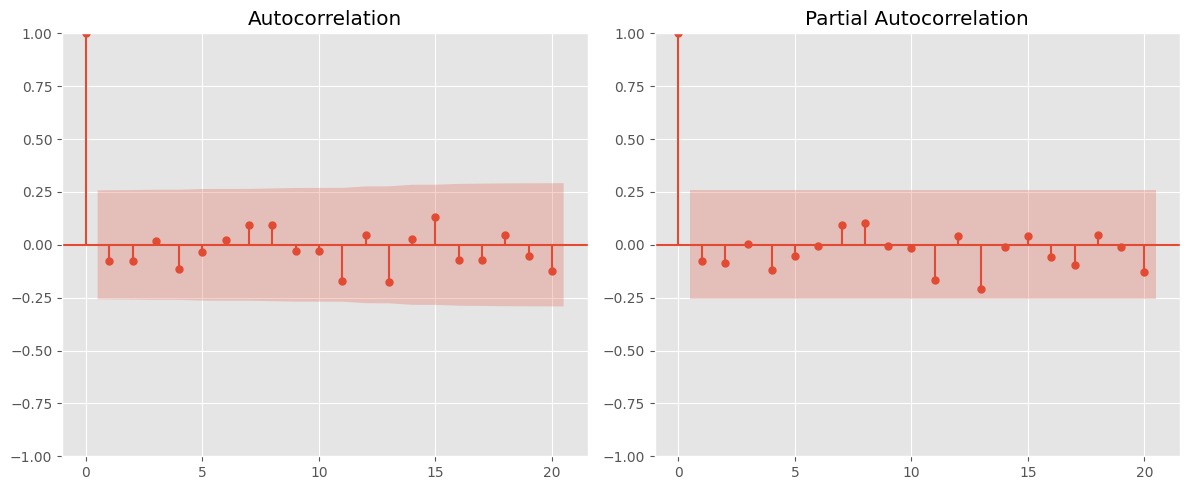

In [43]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
revison_acf = plot_acf(weekly_pricing_padd5, lags=20, ax=ax) 

ax = fig.add_subplot(1,2,2)
revison_pacf = plot_pacf(weekly_pricing_padd5, lags=20, ax=ax)

plt.tight_layout() 

## **Model-One Revision Adfuller Test** 
- The p-value is less than 0.05, indicating the current pricing is stationary, therefore there is no need to apply differencing at this time. 

In [99]:
model_one_adfuller = adfuller(weekly_pricing_padd5)
pd.DataFrame({'AdFuller-Score': model_one_adfuller[0] , 'P-Value': model_one_adfuller[1] }, index=[1])

,AdFuller-Score,P-Value
1,-7.968735,2.818564e-12


In [47]:
p,d,q = 7,1,7
P,D,Q = 7,0,7
w: int = 7 

pkl_path: str = os.path.expanduser("~/Development/datasets/model_one_revision_padd5.pkl")
optimize_sarimax(p_size=p, d=d, q_size=q, P_size=P, D=D, Q_size=Q, s=w, pkl_path=pkl_path, df=weekly_pricing_padd5)

DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Starting at index 0
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Job Started at 2024-06-20T18:15:51.795712
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(0,0,0,7) @18:15:51
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(0,0,1,7) @18:15:51
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(0,0,2,7) @18:15:51
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(0,0,3,7) @18:15:51
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(0,0,4,7) @18:15:51
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(0,0,5,7) @18:15:52
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(0,0,6,7) @18:15:52
DEBUG:odin_eia_db.statistics.odin_sarimax:[ SUCCESS ]Running model SARIMAX(0,1,0)(1,0,0,7) @18:15:52
DEBUG:odin_eia_db.statis

### **TOP 10: Model-One SARIMAX Parameter After the Optimization**

In [50]:
pd.read_pickle(pkl_path).sort_values(by='AIC').head(10)

,p,q,P,Q,AIC
0,0,0,0,0,2.0
1,0,0,0,1,4.0
343,1,0,0,0,4.0
7,0,0,1,0,4.0
49,0,1,0,0,4.0
392,1,1,0,0,6.0
350,1,0,1,0,6.0
344,1,0,0,1,6.0
56,0,1,1,0,6.0
686,2,0,0,0,6.0


In [99]:
weekly_pricing_padd5 = weekly_pricing_padd5.sort_index()
train: 'Series' = weekly_pricing_padd5[:int(weekly_pricing_padd5.shape[0] * 0.8)]
test: 'Series' =  weekly_pricing_padd5[int(weekly_pricing_padd5.shape[0] * 0.8):]

In [117]:
model_one_revision: SARIMAX = SARIMAX(endog=train,
                                      order=(0,1,0), # using integreation_order 1 
                                      seasonal_order=(0,0,0,0),
                                      simple_differencing=False, 
                                      enforce_stationarity=False
                                     ).fit(disp=False) 
model_one_revision.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              avg_price   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  46.828
Date:                Thu, 20 Jun 2024   AIC                            -91.655
Time:                        18:51:40   BIC                            -89.871
Sample:                    05-24-2023   HQIC                           -90.993
                         - 04-03-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0070      0.002      3.853      0.000       0.003       0.011
===================================================================================
Ljung-Box (L1) (Q):                  11.89   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               3.45   Skew:                            -0.30
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Model-One Revision Ljung-Box Test**
- Applying the integration order, by setting d=1 shows that the p-value > 0.05. 

In [118]:
acorr_ljungbox(model_one_revision.resid, lags=20)

,lb_stat,lb_pvalue
1,0.012417,0.911276
2,0.052245,0.974216
3,0.076076,0.994545
4,0.079753,0.999226
5,0.091973,0.999868
6,0.091990,0.999984
7,0.091991,0.999998
8,0.092850,1.000000
9,0.096511,1.000000
10,0.130869,1.000000


### **Model One Revision Diagnostic Plot** 
- The correlogram shows that there is a significant coefficient at lag 1-3. 

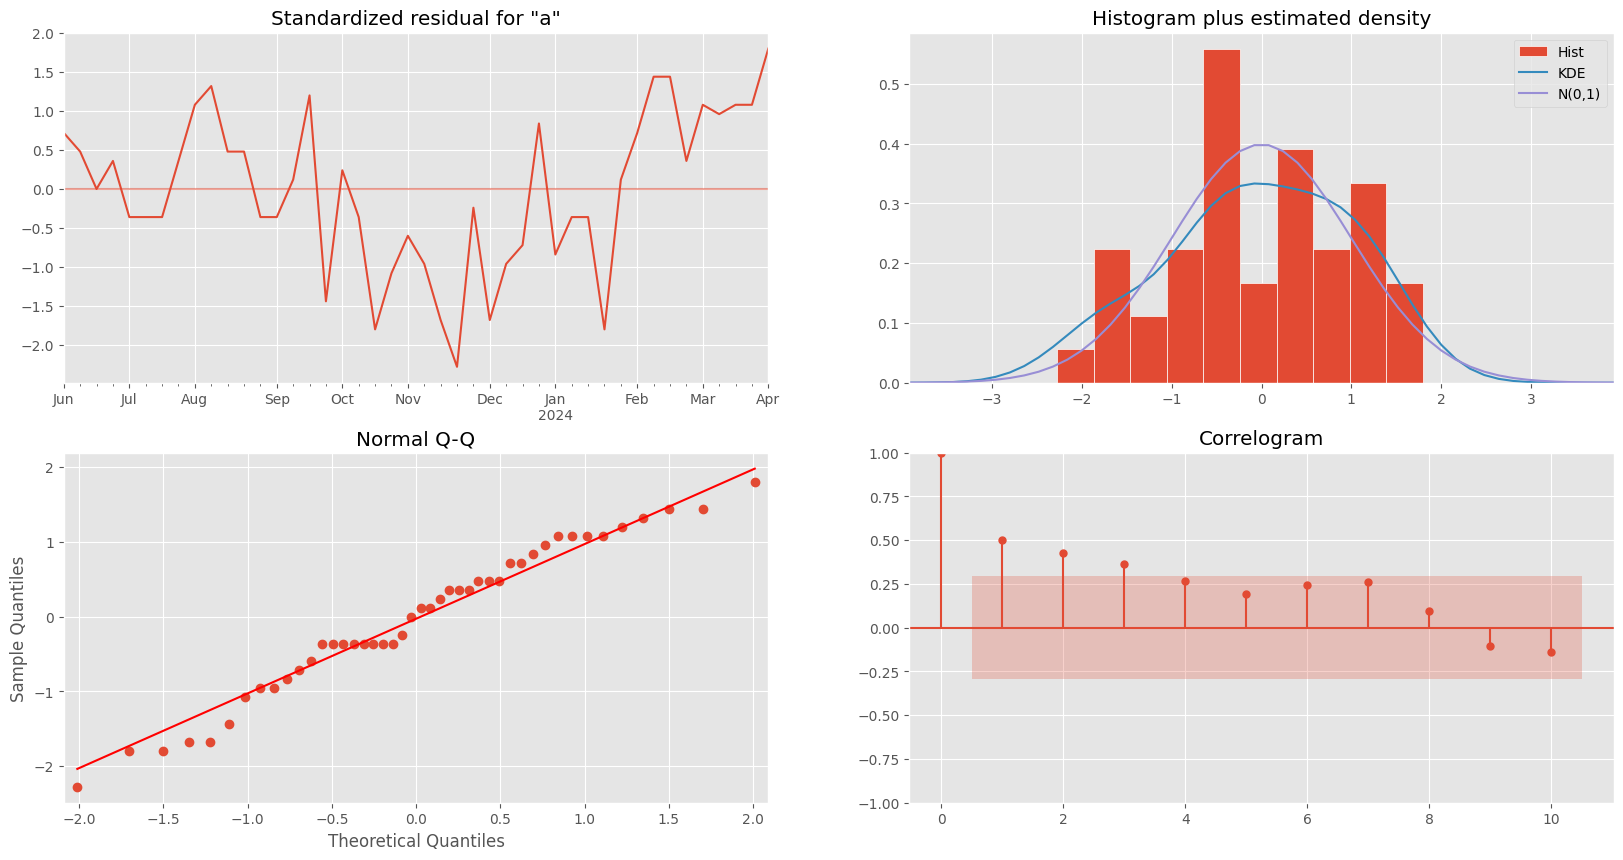

In [103]:
ax = model_one_revision.plot_diagnostics(figsize=(20,10))

## **Model-One-Revision: Forecasting Weekly Gasoline Pricing in `PADD 5` District**
- Model-One-Revision cannot correctly capture the weekly gasoline pricing, as it predicts the mean value

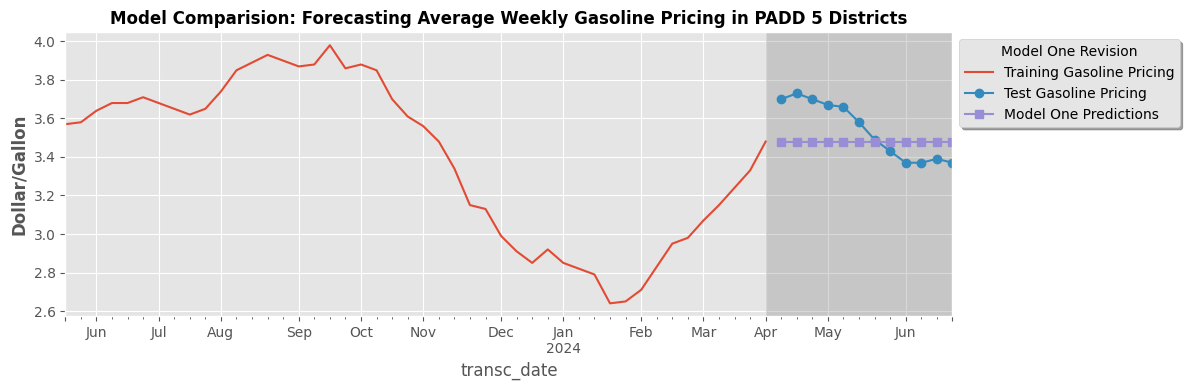

In [132]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
train.plot(ax=ax, label='Training Gasoline Pricing') 
test.plot(ax=ax, label='Test Gasoline Pricing', marker='o') 
model_one_revision.forecast(steps=test.shape[0]).plot(ax=ax, label='Model One Predictions', marker='s')
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.legend(bbox_to_anchor=(1,1), title='Model One Revision', fancybox=True, shadow=True)
ax.axvspan(xmin=2831, xmax=2843, alpha=0.3, color='grey')
ax.set_title("Model Comparision: Forecasting Average Weekly Gasoline Pricing in PADD 5 Districts", fontweight='bold', fontsize=12)
plt.tight_layout()

# **Model Two: Applying Federal and State Tax For Gasoline Pricing in `PADD 5` District**
- Improving Model One by using exogenous variables such as Federal/State Tax 

In [22]:
state_tax_padd5: Dict = tax_df.query("PADD_Distric == 'PADD 5' ").iloc[:,:2].set_index('State').rename({'Gasoline tax (¢/gal)': 'state_tax'}, axis=1 ).to_dict().get('state_tax') 
args: str = ','.join( [ "'%s'" % (STATES_LOOKUP.get(state)) for state in state_tax_padd5 ] )

## **ISO-Butane Production in the U.S** 
- Isobutane is a chemical variation of `butane` and used in gasoline mixtures to help with performance in cold weather (Unit: `Thousand Barrels/Day`). 

In [48]:
isobutane_prod: 'DataFrame' = pd.read_excel( "https://www.eia.gov/dnav/pet/hist_xls/M_EPLLBAI_FPF_NUS_MBBLDm.xls", sheet_name='Data 1')
isobutane_prod.columns = isobutane_prod.iloc[1]
isobutane_prod = isobutane_prod.iloc[2:]
# Different mixtures used during cold weather, such as butane
isobutane_prod['Date'] = pd.to_datetime(isobutane_prod['Date'] ) 
isobutane_prod.columns = ['Date', 'Value']

isobutane_prod.head()

1,Date,U.S. Field Production of Isobutane (Thousand Barrels per Day)
2,1981-01-15,119
3,1981-02-15,114
4,1981-03-15,112
5,1981-04-15,122
6,1981-05-15,120


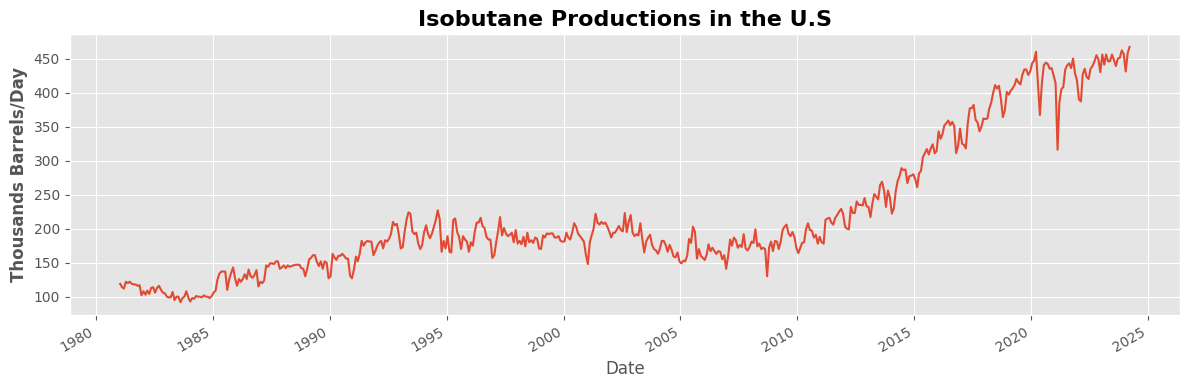

In [57]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot() 
isobutane_prod.set_index('Date')['Value'].plot(ax=ax)
ax.set_title("Isobutane Productions in the U.S", fontweight='bold', fontsize=16)
ax.set_ylabel("Thousands Barrels/Day", fontweight='bold')

plt.tight_layout() 
fig.autofmt_xdate() 

In [67]:
query: str = f"""
WITH gasoline_pricing_in_padd5 AS 
(( SELECT 
    g.state,
    DATE_FORMAT(g.postedtime, '%Y-%m-%d' ) AS `transc_date`,
    MONTHNAME(DATE_FORMAT(g.postedtime, '%Y-%m-%d' )) AS `month_name`,
    MONTH(DATE_FORMAT(g.postedtime, '%Y-%m-%d' )) AS `month`,
    CAST(g.price AS DECIMAL ) AS `price`
    
FROM gasoline_pricing g 
WHERE g.state IN ({args}) AND g.state != 'NULL' AND g.price > 0 )

UNION ALL 

SELECT 
    l.state, 
    DATE_FORMAT(l.timestamp, '%Y-%m-%d' ) AS `transc_date`,
    MONTHNAME(DATE_FORMAT(l.timestamp, '%Y-%m-%d' )) AS `month_name`,
    MONTH(DATE_FORMAT(l.timestamp, '%Y-%m-%d' )) AS `month`,
    CAST(l.price AS DECIMAL ) AS `price`
    
FROM legacy_gasoline_pricing l 
WHERE l.state IN ({args}) AND l.state != 'NULL' AND l.price > 0 )

SELECT 
    g.state, 
    g.transc_date, 
    g.month_name, 
    g.month, 
    g.price, 
    p.value -- unit MBBL 

FROM gasoline_pricing_in_padd5 g 
JOIN petroleum_motor_gasoline_stocks p ON p.period = DATE_FORMAT(g.transc_date, '%Y-%m' ) -- equals to the stock-period
WHERE p.product_name = 'Total Gasoline' AND p.area_name = 'PADD 5'  

"""
gasoline_pricing_df: 'PADD5' =  ODINSpark(app_name="PADD 5 District: Gasoline Pricing & Stocks").exec_odin_mysql_query(query=query) 
gasoline_pricing_df = gasoline_pricing_df.withColumnRenamed('value', 'stock_value')

DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmms   
          `hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdsoo+ososmmmmmmmmmmmmmmmmmmmm

:: loading settings :: url = jar:file:/opt/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8de00f66-bc7a-497e-b233-3aed0b98a9c4;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 470ms :: artifacts dl 15ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evi

In [68]:
gasoline_pricing_df.printSchema() 

root
 |-- state: string (nullable = true)
 |-- transc_date: string (nullable = true)
 |-- month_name: string (nullable = true)
 |-- month: long (nullable = true)
 |-- price: decimal(10,0) (nullable = true)
 |-- value: string (nullable = true)



In [69]:
gasoline_pricing_df.show(2) 

+-----+-----------+----------+-----+-----+-----+
|state|transc_date|month_name|month|price|value|
+-----+-----------+----------+-----+-----+-----+
|   HI| 2023-05-21|       May|    5|    4|29366|
|   HI| 2023-05-21|       May|    5|    4|29366|
+-----+-----------+----------+-----+-----+-----+
only showing top 2 rows



## **Gasoline Pricing in `PADD 5` District** 

In [100]:
odin_spark: ODINSpark = ODINSpark(app_name='U.S Isobutane Production')
spark_isobutane = odin_spark.start() 
us_isbn_prod: 'DataFrame' = spark_isobutane.createDataFrame(isobutane_prod) 
us_isbn_prod = us_isbn_prod.withColumn('transc_date', f.date_format('Date', 'yyyy-MM-dd' ) )

pricing_df: 'PADD5' = gasoline_pricing_df.join(us_isbn_prod, on='transc_date', how='left') # join pricing + isobutane production for exog_vars 
pricing_df = pricing_df.fillna(0)

df: 'DataFrame' = pricing_df.select('transc_date', 'state', 'month_name', 'month', 'price', 'stock_value', 'Value' ).toPandas() 
df['price'] = df['price'].astype(float) 
df['transc_date'] = pd.to_datetime(df['transc_date'])


DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmms   
          `hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdsoo+ososmmmmmmmmmmmmmmmmmmmm

In [102]:
pricing_df.printSchema() 

root
 |-- transc_date: string (nullable = true)
 |-- state: string (nullable = true)
 |-- month_name: string (nullable = true)
 |-- month: long (nullable = true)
 |-- price: decimal(10,0) (nullable = true)
 |-- stock_value: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Value: long (nullable = true)



In [144]:
df.head(2)

,transc_date,state,month_name,month,price,stock_value,Value,state_name
0,2024-01-19,NV,January,1,2.0,31638,0,Nevada
1,2024-01-19,NV,January,1,2.0,31638,0,Nevada


## **Overal Distribution of Gasoline Price in PADD 5 District** 

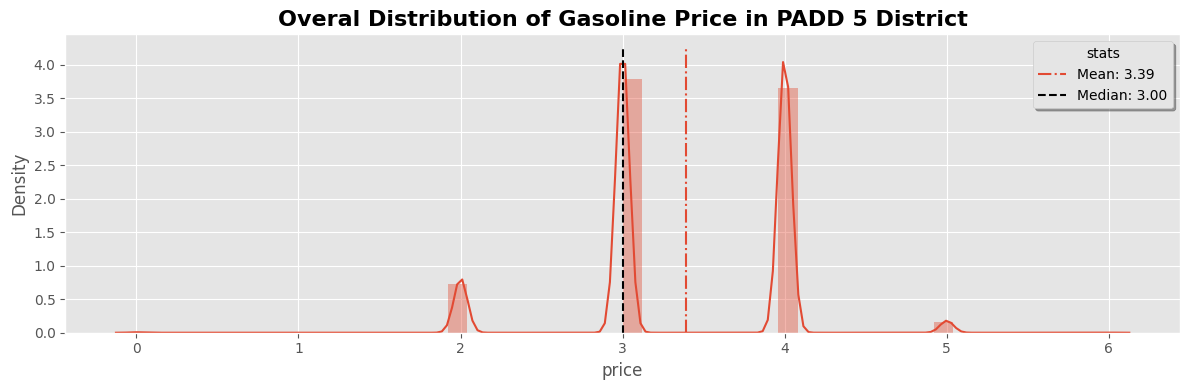

In [120]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot()
sns.distplot(df['price'] , ax=ax)
ax.set_title("Overal Distribution of Gasoline Price in PADD 5 District", fontweight='bold', fontsize=16)

mean: float = df['price'].mean() 
median: float = df['price'].median() 
ymin,ymax = ax.get_ylim() 
ax.vlines(x=mean, ymin=ymin, ymax=ymax, label=f'Mean: {mean:.2f}', linestyles='-.')
ax.vlines(x=median, ymin=ymin, ymax=ymax, label=f'Median: {median:.2f}', linestyles='--', color='black')
ax.legend(title='stats', fancybox=True, shadow=True)

plt.tight_layout() 

## **Histogram of Gasoline Price in PADD 5 District By State** 

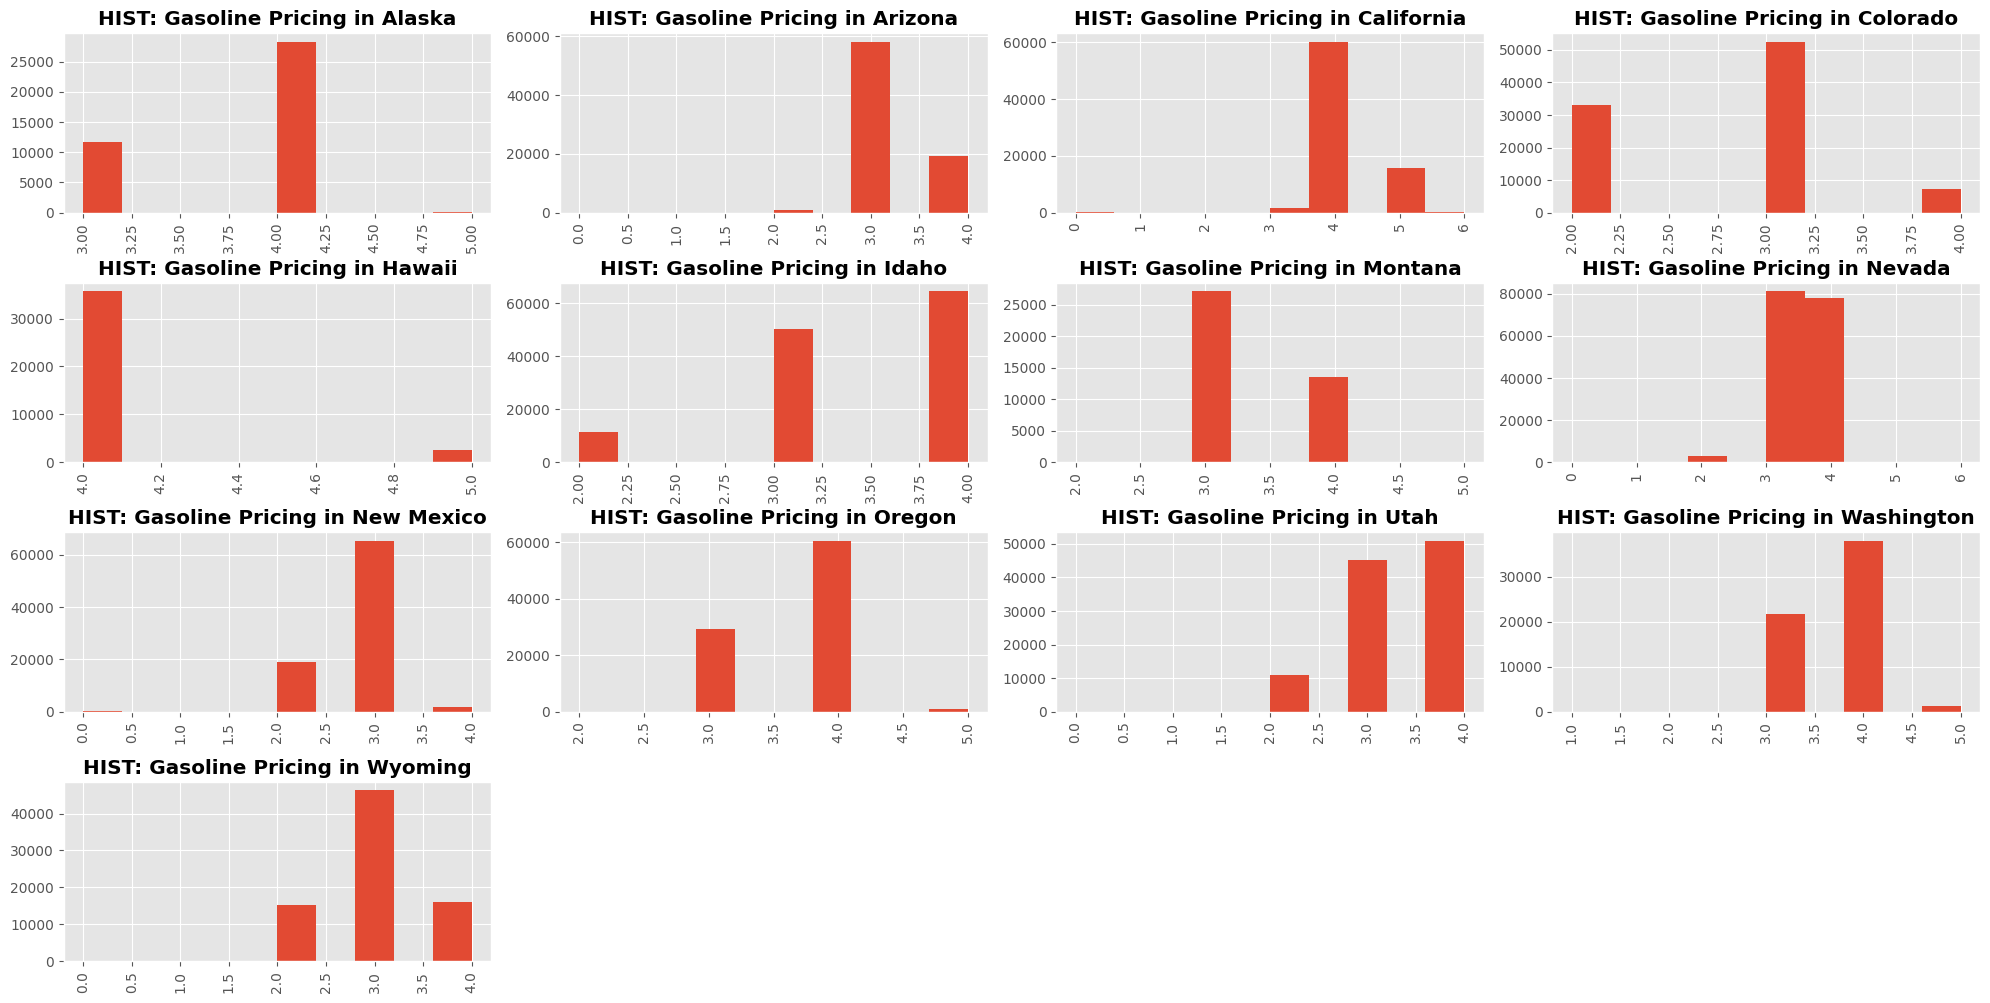

In [136]:
df['state_name']  = df['state'].apply(lambda row: INVERSE_STATES.get(row) ) 
plt.rcParams['figure.figsize'] = (20,10)
axs = df.sort_values(by='state_name').hist(by='state_name', column='price')

for ax in axs.flatten():
    ax.set_title("HIST: Gasoline Pricing in %s" % ( ax.get_title()) , fontweight='bold')

plt.tight_layout() 

## **Compare Gasoline Pricing in `PADD 5` District** 

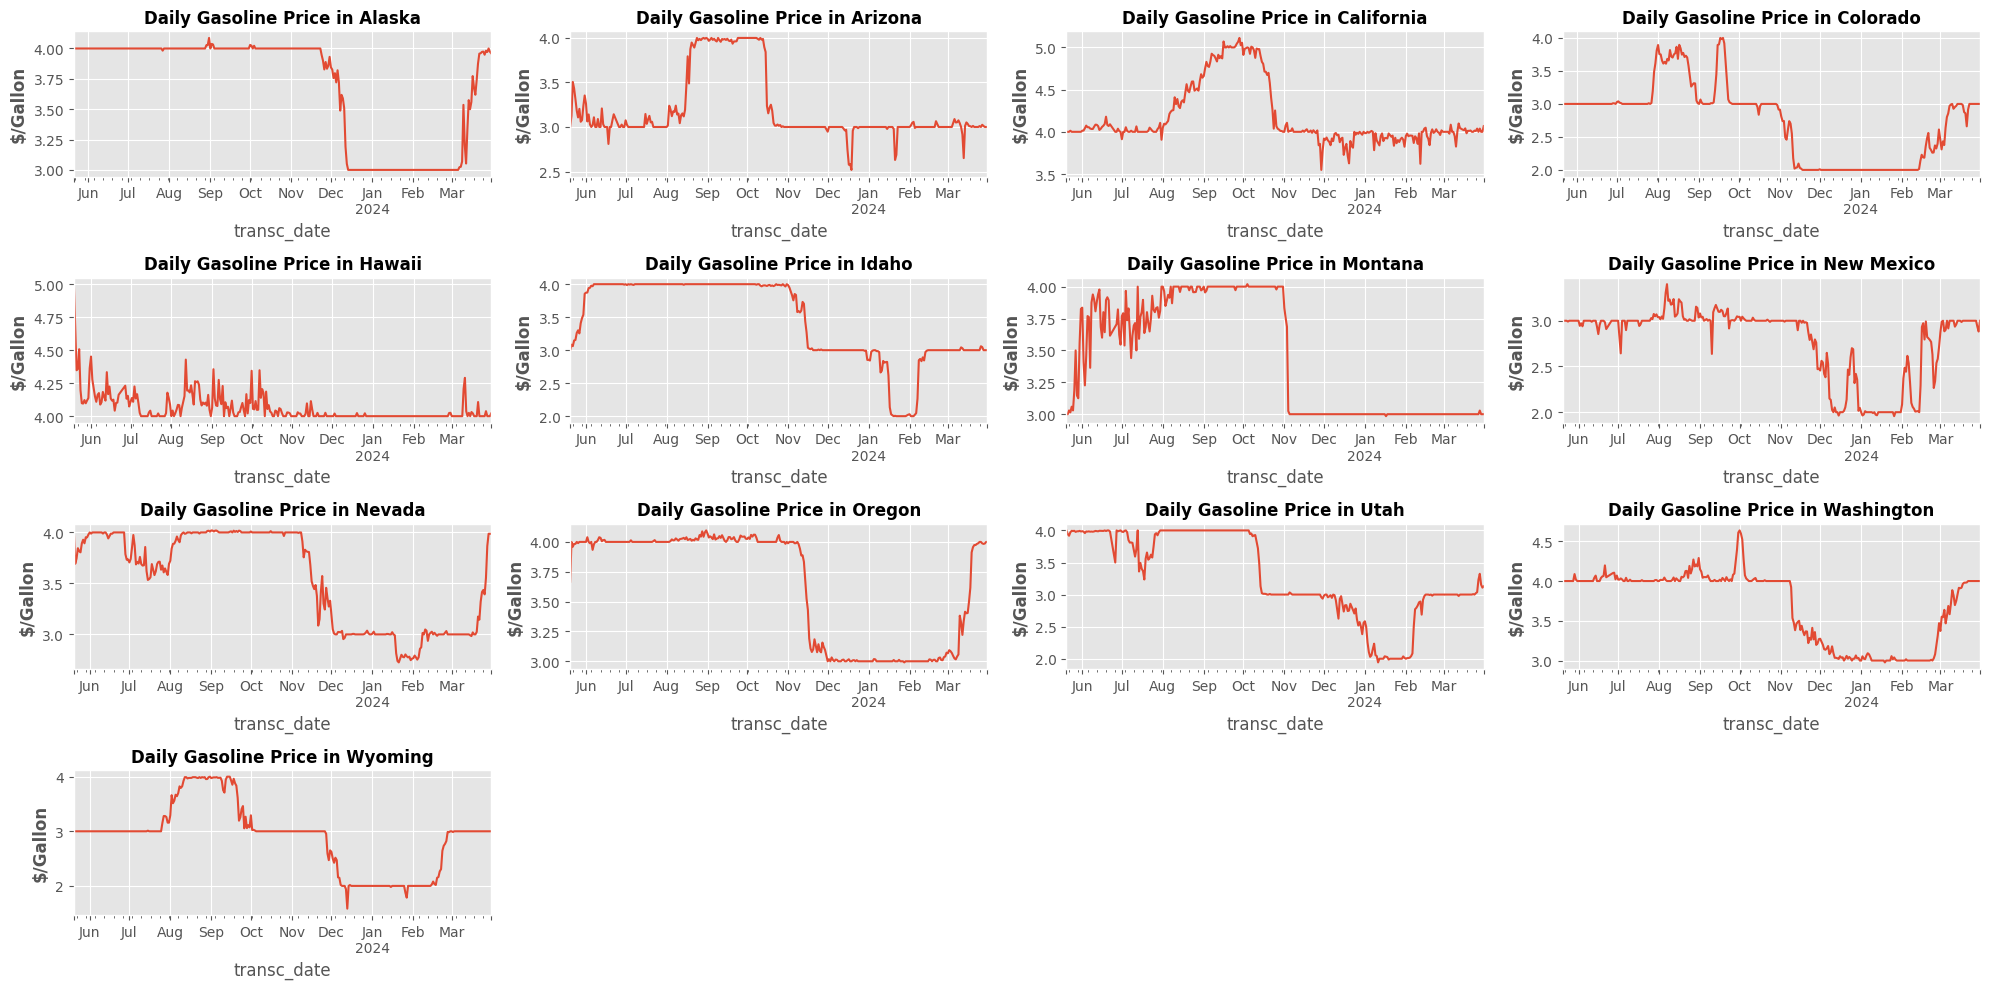

In [159]:
fig = plt.figure(figsize=(20,10))
for index,state in enumerate( sorted( df['state'].unique()), 1): 

    ax = fig.add_subplot(4,4,index)
    df.query(f"state == '{state}' ").set_index('transc_date')['price'].resample('1D').mean().interpolate().plot(ax=ax)
    ax.set_title(f"Daily Gasoline Price in {INVERSE_STATES.get(state)}", fontweight='bold', fontsize=12)
    ax.set_ylabel("$/Gallon", fontweight='bold')

plt.tight_layout() 

## **PADD 5 Gasoline Pricing by Month**

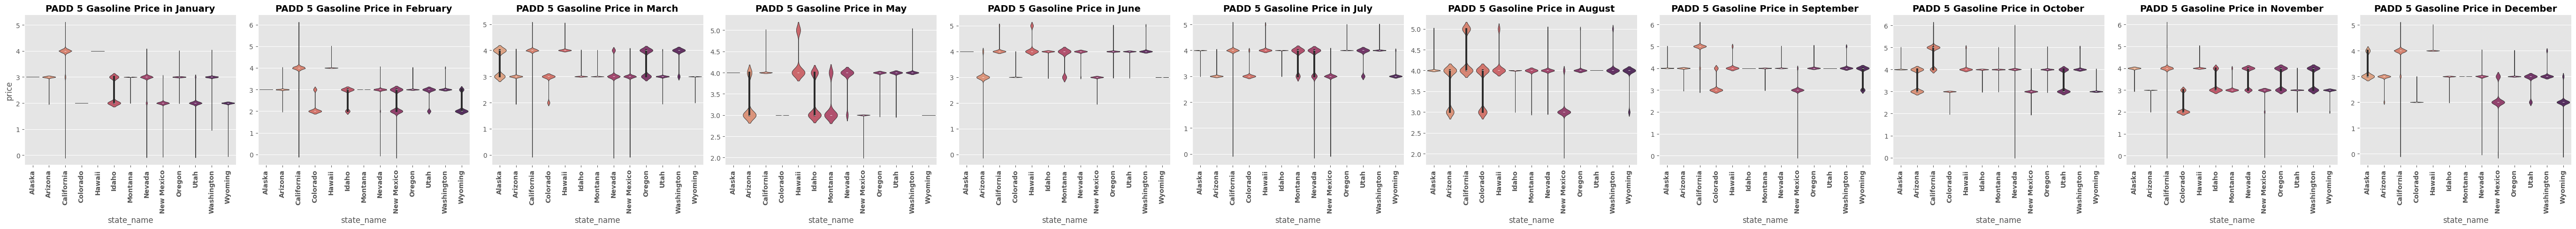

In [188]:
axs = sns.catplot(data=df.sort_values(by='state_name'), x='state_name', y='price', col='month', kind='violin', palette='flare', sharey=False) 
month_lookup: Dict = df[['month','month_name']].drop_duplicates().sort_values(by='month').set_index('month').to_dict().get('month_name') 

for ax in axs.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='bold')
    ax.set_title(f"PADD 5 Gasoline Price in {month_lookup.get(int( ax.get_title().split('=')[-1].strip() ))}", fontweight='bold', fontsize=14)

plt.tight_layout() 

## **Decompose Seasonal Trends (Gasoline Pricing in Padd 5 District Washington)** 

In [192]:
wa_pricing: 'Series' = df.query("state_name == 'Washington' ").set_index('transc_date')['price'].resample('W').mean().interpolate().sort_index().apply(lambda row: round(row,2))
transc_dates, avg_price = zip(*wa_pricing.to_dict().items())
wa_stl: STL = STL(wa_pricing, period=7).fit() 

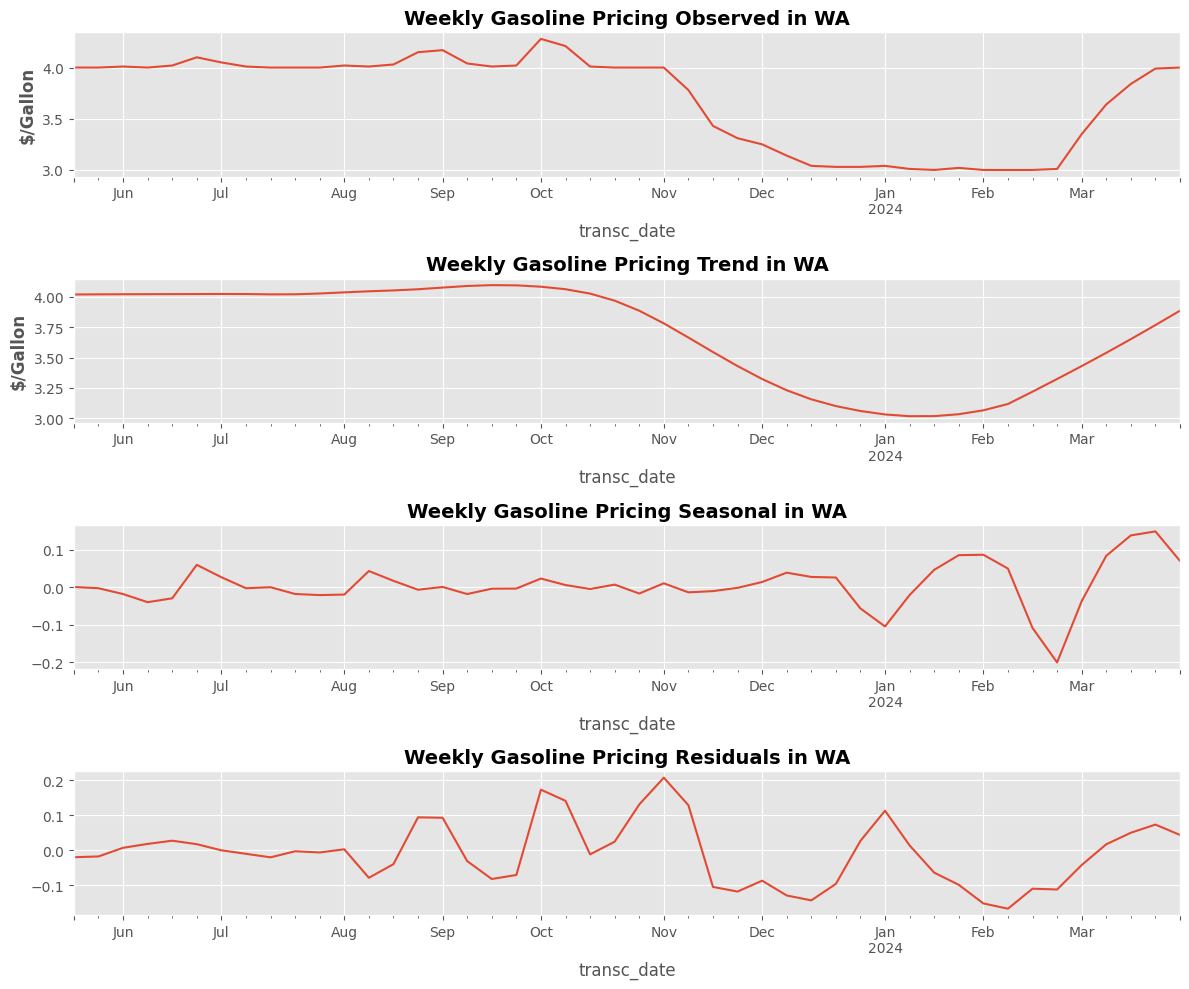

In [211]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(4,1,1)
wa_stl.observed.plot(ax=ax)
ax.set_title("Weekly Gasoline Pricing Observed in WA", fontweight='bold', fontsize=14)
ax.set_ylabel("$/Gallon", fontweight='bold')
ax = fig.add_subplot(4,1,2)
wa_stl.trend.plot(ax=ax)
ax.set_title("Weekly Gasoline Pricing Trend in WA", fontweight='bold', fontsize=14)
ax.set_ylabel("$/Gallon", fontweight='bold')

ax = fig.add_subplot(4,1,3)
wa_stl.seasonal.plot(ax=ax)
ax.set_title("Weekly Gasoline Pricing Seasonal in WA", fontweight='bold', fontsize=14)

ax = fig.add_subplot(4,1,4)
wa_stl.resid.plot(ax=ax)
ax.set_title("Weekly Gasoline Pricing Residuals in WA", fontweight='bold', fontsize=14)

plt.tight_layout() 

## **Adfuller Test for WA Pricing (PADD 5)**

In [268]:
wa_df: 'DataFrame' =pd.merge(left=df.query("state == 'WA' "), right=pd.DataFrame({'transc_date': list(transc_dates), 'avg_price': list(avg_price)} ), on='transc_date' , how='right' ).drop_duplicates()[['transc_date', 'month', 'price', 'stock_value', 'Value', 'avg_price']]
wa_df['Value'] = wa_df['Value'].replace({np.nan:0.0})
wa_df = wa_df.rename({'Value': 'isobutane'}, axis=1)
wa_df['stock_value'] = wa_df['stock_value'].astype(float) 
wa_df['price'] = wa_df['price'].replace({np.nan:0.0})
wa_df = wa_df.replace({np.nan:12.0})
wa_endog: 'Series' = wa_df.set_index('transc_date')['avg_price'].sort_index() 
wa_exog: 'Series' = wa_df.set_index('transc_date')[['month','stock_value','isobutane']]

### **Adfuller Test** 
- The Adf statistic is small negative number and the p-value is less than 0.05 (`5%`), indicating that the gasoline WA pricing is not stationary yet. 

In [269]:
wa_adf: 'Adfuller' = adfuller( wa_endog ) 
pd.DataFrame({'ADF': wa_adf[0] , 'P-Value': wa_adf[1] }, index=[1])

,ADF,P-Value
1,-2.232856,0.194538


### **Applying First Order Differencing** 
- After applying first-order differencing, the ADF statistic becomes large negative number and the p-value is greater than 0.05, therefore the pricing data is not yet stationary.

In [270]:
wa_adf: 'Adfuller' = adfuller( np.diff(wa_endog, n=1) ) 
pd.DataFrame({'ADF': wa_adf[0] , 'P-Value': wa_adf[1] }, index=[1])

,ADF,P-Value
1,-2.98258,0.036553


## **Applying Seasonal Differencing** 
- After applying seasonal differencing, the ADF statistic becomes a large negative number and the p-value is less than 0.05. Therefore the pricing data is stationary. 

In [272]:
wa_adf: 'Adfuller' = adfuller( np.diff( np.diff(wa_endog, n=1), n=7 ) ) 
pd.DataFrame({'ADF': wa_adf[0] , 'P-Value': wa_adf[1] }, index=[1])

,ADF,P-Value
1,-7.4432,5.930899e-11


## **Optimizing SARIMAX: Find the best model params with the lowest AIC score** 

In [293]:
# pkl_path: str = os.path.expanduser("~/Development/datasets/model_two_sarimax_withexog.pkl")
# optimize_samirx_with_exog(p_size=7,d=1,q_size=7,P_size=7,D=1,Q_size=7,s=7, pkl_path=pkl_path, df=wa_endog, exog=wa_exog)

## **Taxes + Crude Oils Stocks at pump** 